In [93]:
# importing frameworks/packages that are required for the model to run

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale
import torch
from torch import nn, optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

<h1>C-MAPSS dataset Exploratory Data Analysis</h1>
The C-MAPSS dataset, a popular benchmark for evaluating the performance of various machine learning models, was employed to assess the efficacy of our proposed modules. This dataset comprises time-series data collected from 21 sensors, which monitor the degradation patterns of aircraft engines, as illustrated in Figure 6. The sensor data encompasses temperature, pressure, and speed measurements from diverse locations within the engine. The dataset is divided into four subsets: FD001, FD002, FD003, and FD004, with their specific characteristics outlined in our literature review. Notably from our initial exploratory data analysis, FD002 and FD004 are considered more intricate due to their larger number of training and testing trajectories, as well as their involvement in six distinct operational conditions.

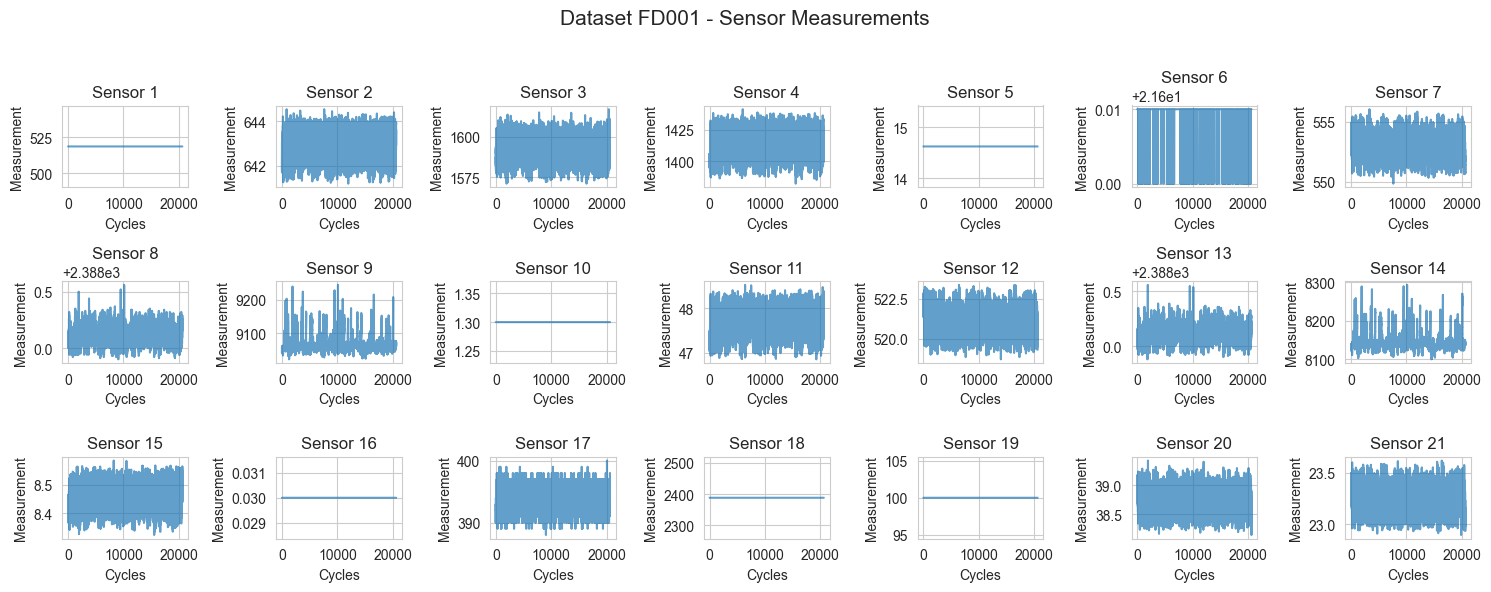

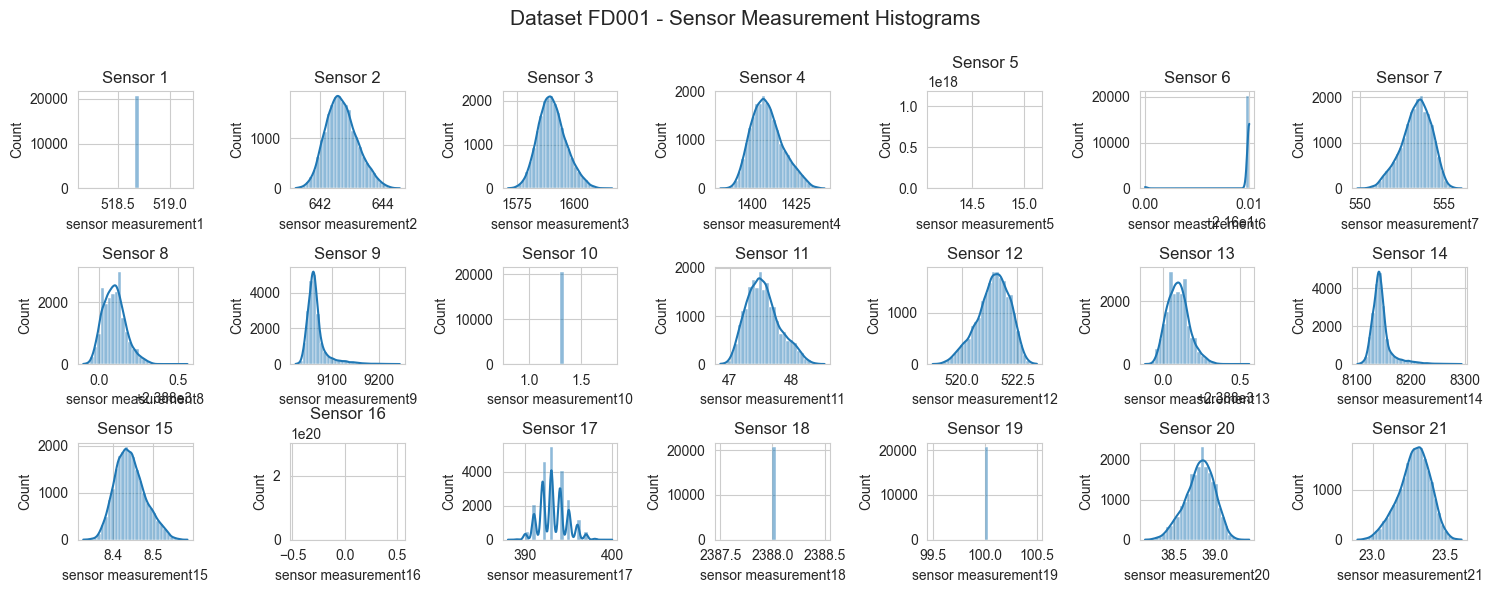

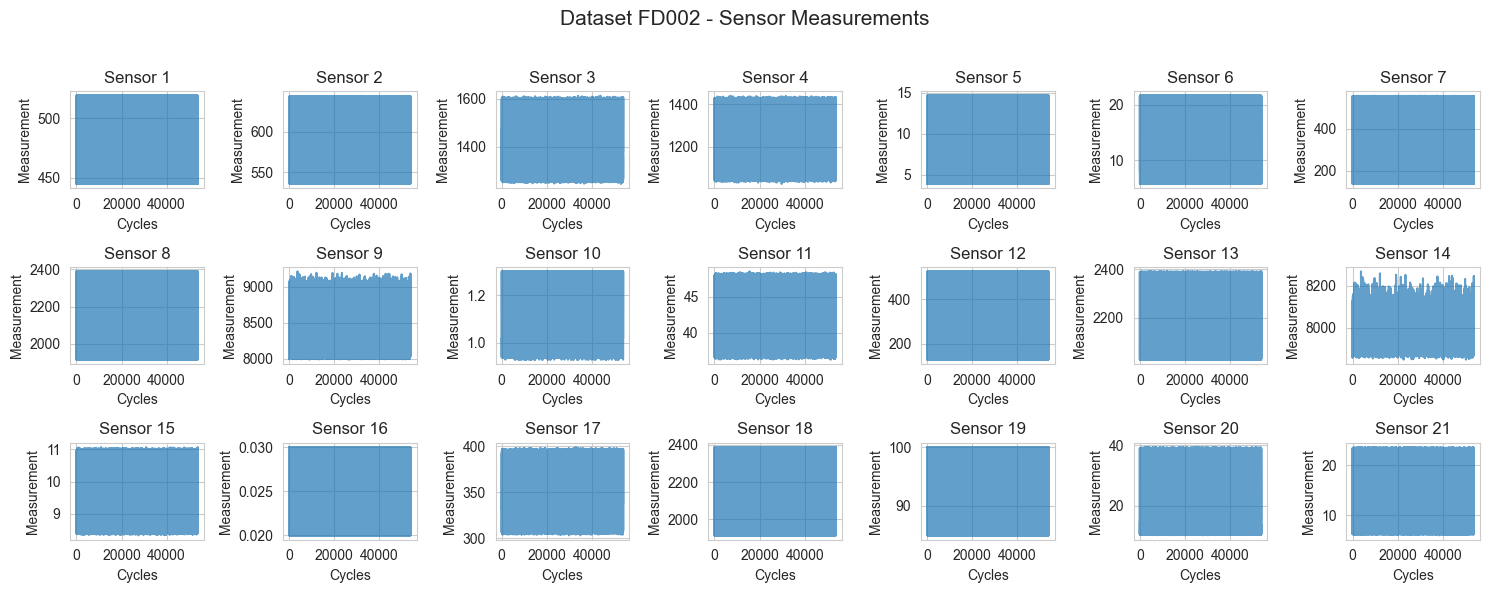

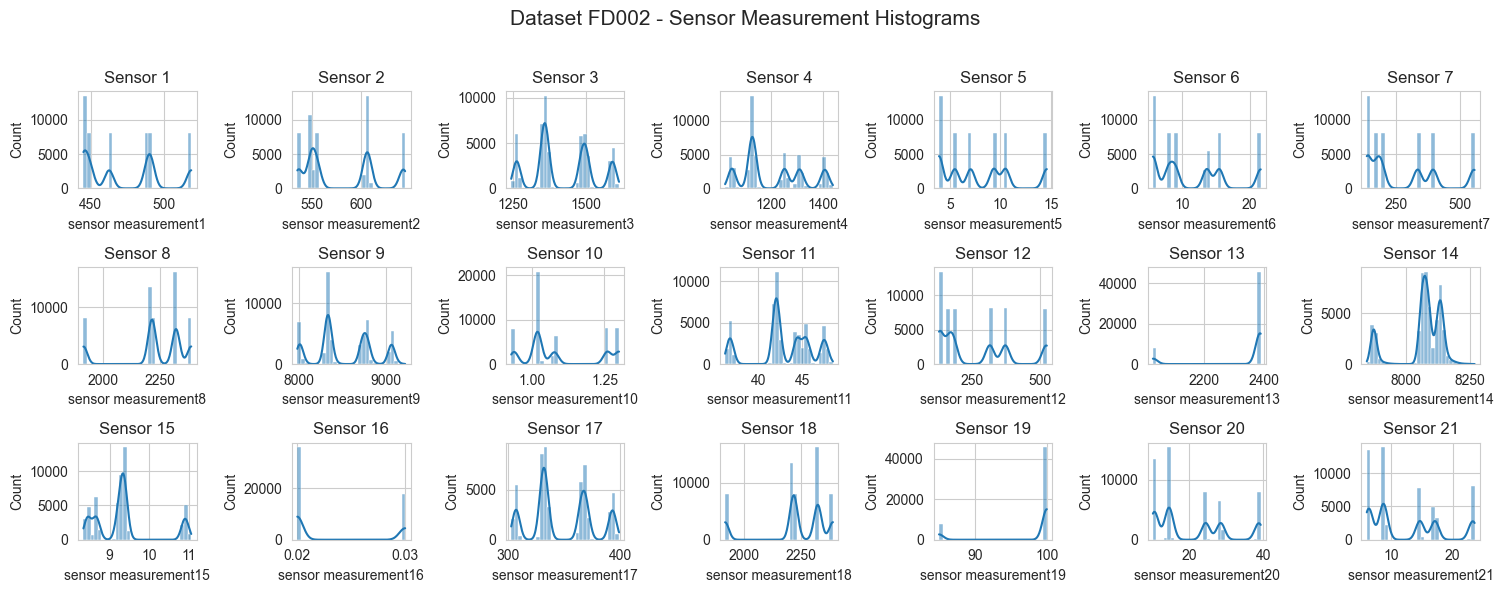

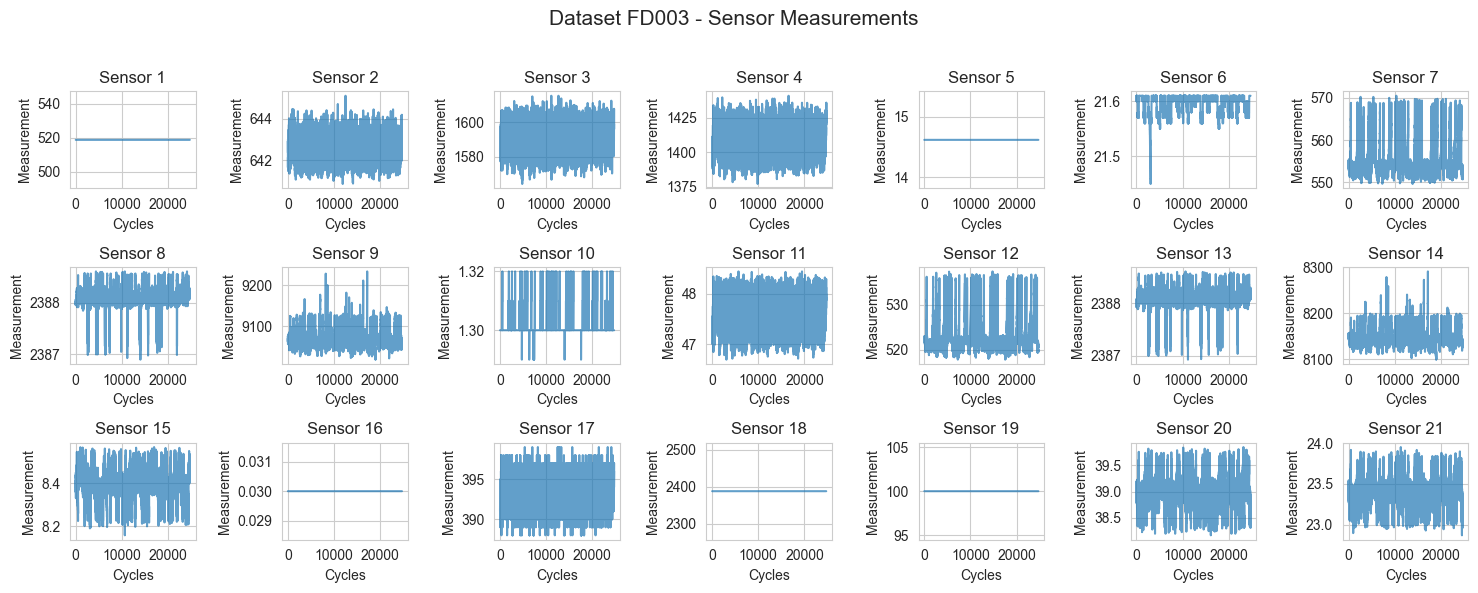

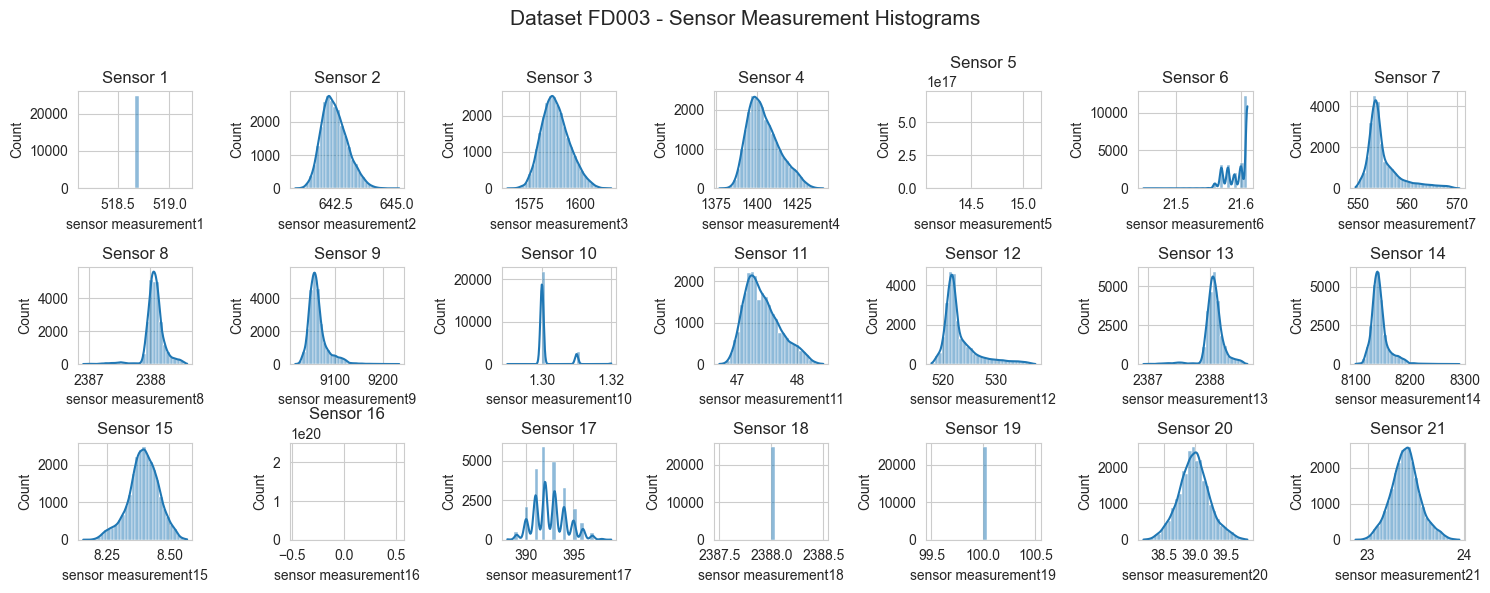

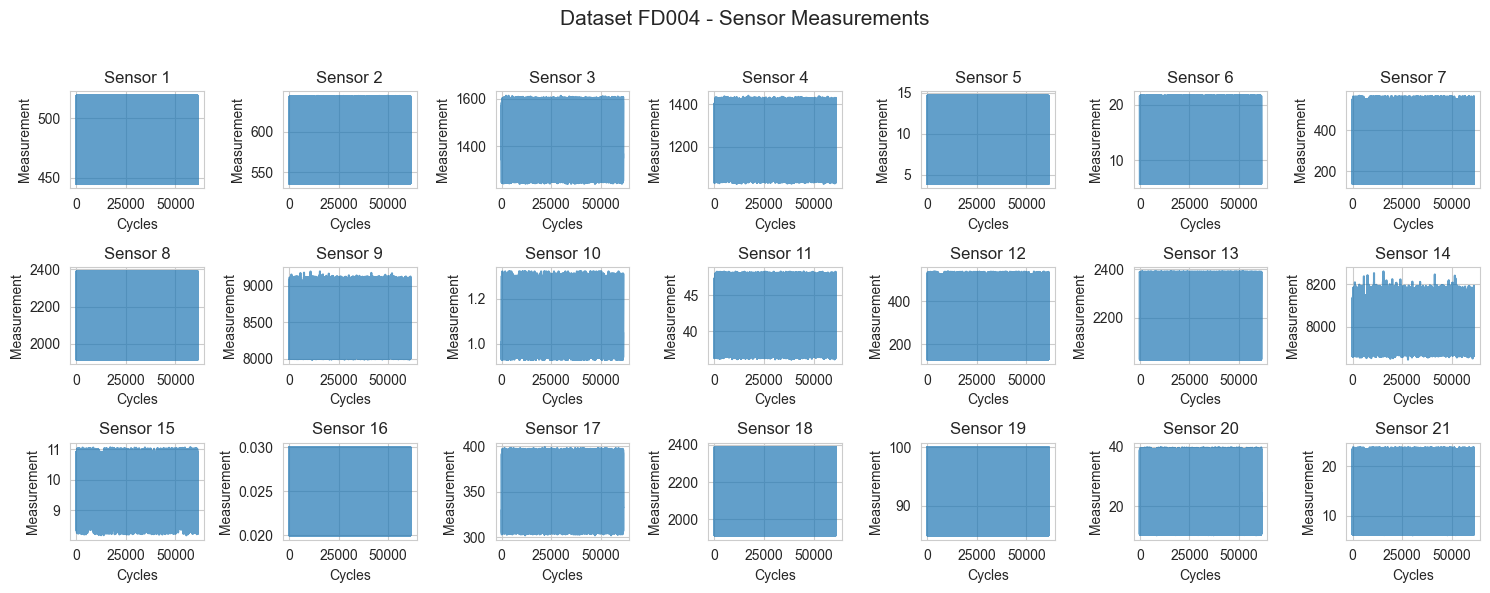

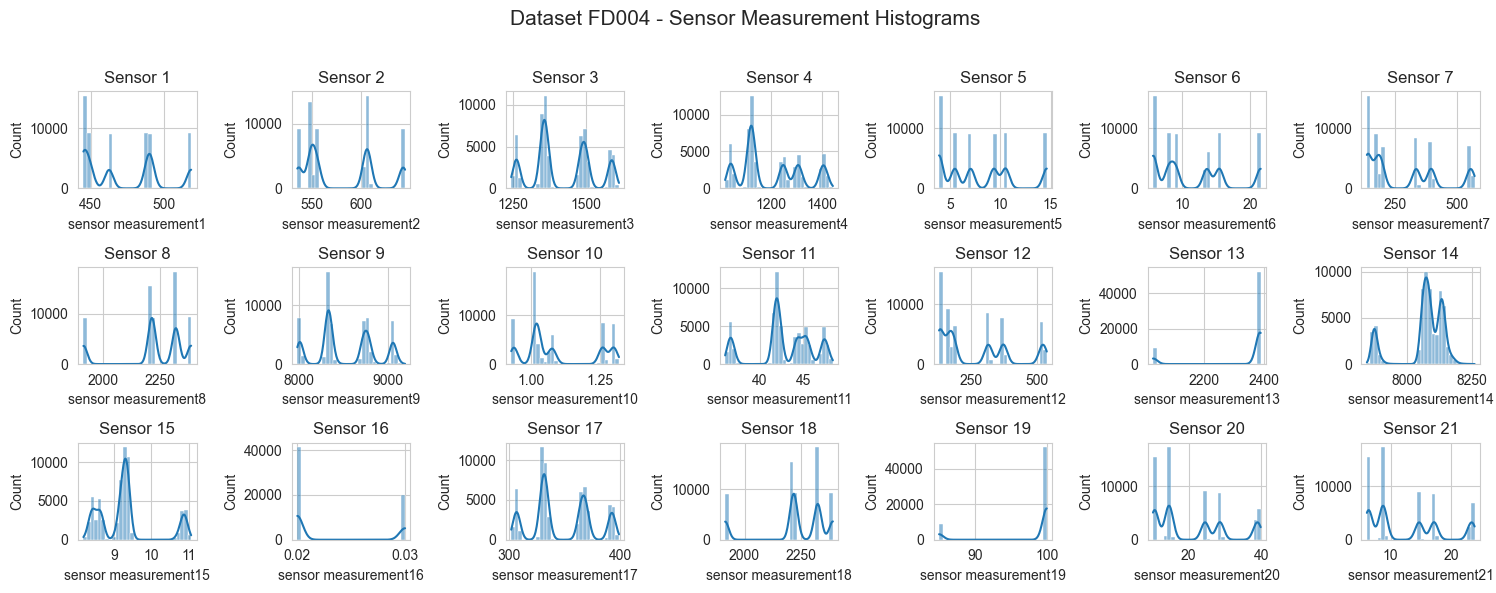

In [94]:
# Set the style for seaborn
sns.set_style("whitegrid")


def data_analysis_plot(j):
    # Load the dataset
    raw1 = np.loadtxt("dataset/train_FD00" + str(j) + ".txt")
    df1 = pd.DataFrame(
        raw1,
        columns=[
            "unit",
            "cycles",
            "operational setting 1",
            "operational setting 2",
            "operational setting 3",
        ]
        + ["sensor measurement" + str(i) for i in range(1, 22)],
    )

    # Plot sensor measurement time series
    plt.figure(figsize=(15, 6))
    plt.suptitle("Dataset FD00" + str(j) + " - Sensor Measurements", fontsize=15)
    for i in range(1, 22):
        plt.subplot(3, 7, i)
        plt.title("Sensor " + str(i), fontsize=12)
        plt.plot(df1.iloc[:, i + 4], alpha=0.7)
        plt.xlabel("Cycles")
        plt.ylabel("Measurement")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plot histograms of sensor measurements
    plt.figure(figsize=(15, 6))
    plt.suptitle("Dataset FD00" + str(j) + " - Sensor Measurement Histograms", fontsize=15)
    for i in range(1, 22):
        plt.subplot(3, 7, i)
        plt.title("Sensor " + str(i), fontsize=12)
        sns.histplot(df1.iloc[:, i + 4], kde=True, bins=30)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


if __name__ == "__main__":
    # Iterate through datasets
    for dataset_number in range(1, 5):
        data_analysis_plot(dataset_number)

<h1>Exploratory Data Analysis on FD001</h1>

Data Preparation:

While the C-MAPSS dataset contains 21 sensors, certain sensors provide constant values, limiting their usefulness for our task. In line with previous research [8, 9], we eliminated these redundant sensors, focusing on the remaining 14. To process the time-series data, we employed a sliding window technique [5, 9, 37] with a window size of 30. For sequences shorter than 30, we padded them with the initial value. Data normalization is a crucial step in RUL prediction, and we adopted min-max normalization as suggested in [8]. To enhance the accuracy of RUL predictions, we incorporated piece-wise linear scaling for RUL values [38], capping the maximum RUL at 125.

<h2>Understanding the Piecewise Labeling</h2>

**Objective of Labeling:**

The goal is to create an RUL label for each cycle within a time window that reflects the number of cycles left before the unit fails. The RUL label decreases over time as the unit progresses through its lifecycle.

**Piecewise Label with a Cap:**

Instead of allowing RUL to decrease all the way to zero, the code applies a piecewise cap on the RUL values at 125 cycles. This means that any calculated RUL greater than 125 is set to 125.

**Why Cap the RUL?**

In practice, equipment degradation might not be linear. Beyond a certain point, the RUL values become less informative as they exceed a certain threshold.
Setting a cap at 125 helps standardize labels for cycles that are far from failure, which can make models easier to train and generalize. It reduces noise from high RUL values that may not have a strong predictive signal.

Train DataFrame shape: (20631, 26)
Test DataFrame shape: (13096, 26)


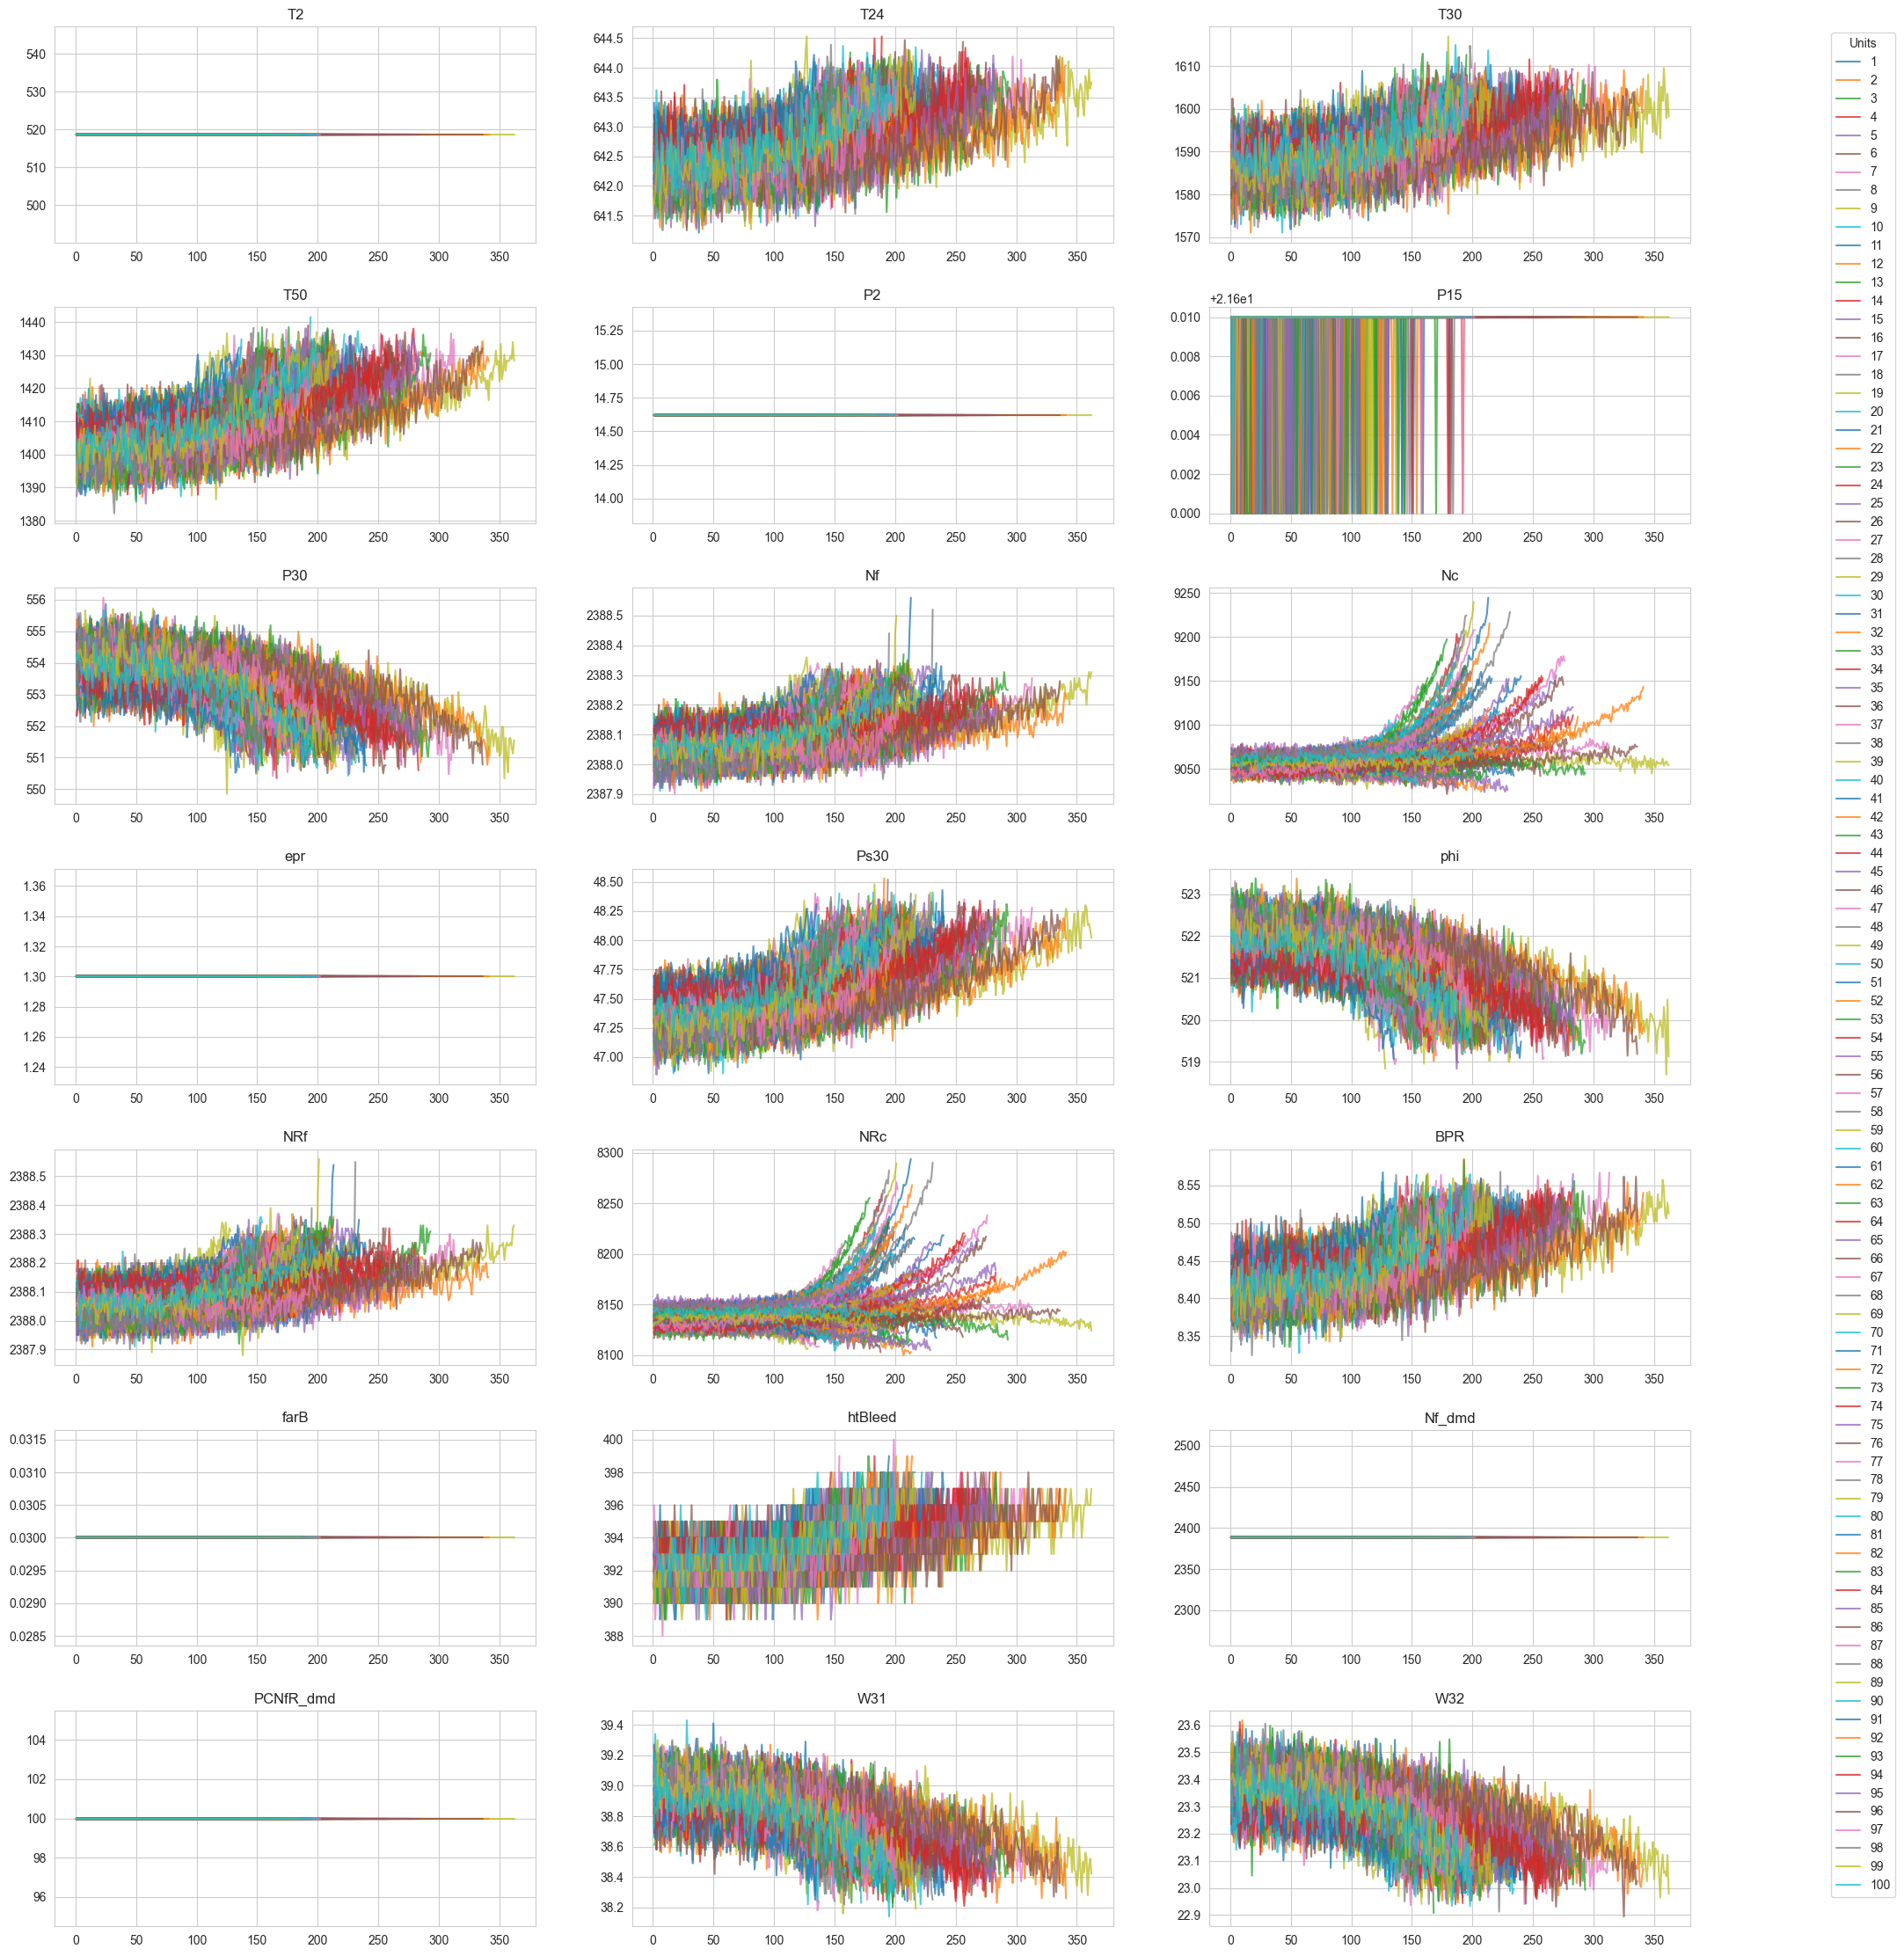

Remaining columns in train_df: Index(['unit_ID', 'cycles', 'setting_1', 'setting_2', 'setting_3', 'T24',
       'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR',
       'htBleed', 'W31', 'W32'],
      dtype='object')
Remaining columns in test_df: Index(['unit_ID', 'cycles', 'setting_1', 'setting_2', 'setting_3', 'T24',
       'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR',
       'htBleed', 'W31', 'W32'],
      dtype='object')


In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set_style("whitegrid")


def load_and_clean_data(train_path, test_path, rul_path, columns, truth_columns):
    # Load datasets
    train_df = pd.read_csv(train_path, sep=" ", header=None)
    test_df = pd.read_csv(test_path, sep=" ", header=None)
    rul_df = pd.read_csv(rul_path, sep=" ", header=None)

    # Drop NaN columns and rename columns
    train_df.dropna(axis=1, inplace=True)
    test_df.dropna(axis=1, inplace=True)
    rul_df.dropna(axis=1, inplace=True)
    rul_df.insert(0, "unit_ID", range(1, len(rul_df) + 1))

    train_df.columns = columns
    test_df.columns = columns
    rul_df.columns = truth_columns

    return train_df, test_df, rul_df


def min_max_scale(df, sensor_indices):
    """Data Normalization: The min_max_scale function normalizes each sensor value using 
    min-max scaling, keeping the values between 0 and 1. This helps in piecewise scaling the data, 
    enhancing model performance and making it easier to detect underlying patterns."""
    for i in sensor_indices:
        min_val = df.iloc[:, i].min()
        max_val = df.iloc[:, i].max()
        df.iloc[:, i] = (df.iloc[:, i] - min_val) / (
            max_val - min_val + 1e-8
        )  # Avoid division by zero


def extract_labels_and_time_series(df, rul=None, window_size=30, label_cap=125.0):
    units, values, labels = [], [], []

    for unit in df["unit_ID"].unique():
        unit_data = df[df["unit_ID"] == unit].copy()
        max_cycles = unit_data["cycles"].max()

        for i in range(len(unit_data)):
            if rul is not None:
                # Use true RUL value from rul
                label = min(rul.iloc[unit - 1, 1], label_cap)  # Assuming unit_ID starts from 1
            else:
                # Cap RUL based on cycles
                label = min(max_cycles - unit_data.iloc[i]["cycles"], label_cap)

            labels.append(label)

            # Extract 30-cycle window, padding if needed
            start = max(0, i - window_size + 1) 
            window = unit_data.iloc[start : i + 1, 2:-1].values  # Exclude 'unit_ID' and 'cycles'
            if window.shape[0] < window_size:
                window = np.pad(window, ((window_size - window.shape[0], 0), (0, 0)), "edge")
            values.append(window.flatten())
            units.append(unit)

    return pd.DataFrame(values), units, labels


def plot_sensor_measurements(df, columns):
    fig, ax = plt.subplots(ncols=3, nrows=7, figsize=(24, 24))
    ax = ax.ravel()

    for i, sensor in enumerate(columns[5:]):  # Loop through sensor columns
        for j, unit in enumerate(df["unit_ID"].unique()):
            unit_data = df[df["unit_ID"] == unit]
            if j == 0:  # Add label only for the first unit to avoid duplication
                ax[i].plot(
                    unit_data["cycles"],
                    unit_data[sensor],
                    label=f"Unit {unit}",
                    alpha=0.75,
                )
            else:
                ax[i].plot(unit_data["cycles"], unit_data[sensor], alpha=0.75)

        ax[i].title.set_text(sensor)
        ax[i].legend().set_visible(
            False
        )  # Set to True only if you need individual legends

    plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.3, wspace=0.2)
    # Add a global legend outside the loop for the entire figure if needed
    fig.legend(
        df["unit_ID"].unique(),
        loc="upper right",
        title="Units",
        bbox_to_anchor=(1, 0.95),
    )
    plt.show()


if __name__ == "__main__":
    # Define file paths
    train_path = "dataset/train_FD001.txt"
    test_path = "dataset/test_FD001.txt"
    rul_path = "dataset/RUL_FD001.txt"

    # Define column names
    columns = [
        "unit_ID",
        "cycles",
        "setting_1",
        "setting_2",
        "setting_3",
        "T2",
        "T24",
        "T30",
        "T50",
        "P2",
        "P15",
        "P30",
        "Nf",
        "Nc",
        "epr",
        "Ps30",
        "phi",
        "NRf",
        "NRc",
        "BPR",
        "farB",
        "htBleed",
        "Nf_dmd",
        "PCNfR_dmd",
        "W31",
        "W32",
    ]

    truth_columns = [
        "unit_ID",
        "RUL",
    ]

    # 1. Load and clean data
    train_df, test_df, rul_df = load_and_clean_data(
        train_path, test_path, rul_path, columns, truth_columns
    )

    # Check the shape of the DataFrames
    print("Train DataFrame shape:", train_df.shape)
    print("Test DataFrame shape:", test_df.shape)

    # 2. Data Visualization: Plotting sensor measurements to identify redundant sensor measurements
    plot_sensor_measurements(train_df, columns)

    # 3. Feature Selection: Remove redundant columns based on observations from sensor measurement plots
    columns_to_remove = ["T2", "P2", "P15", "epr", "farB", "Nf_dmd", "PCNfR_dmd"]
    train_df.drop(columns=columns_to_remove, inplace=True)
    test_df.drop(columns=columns_to_remove, inplace=True)

    # Check remaining columns after dropping
    print("Remaining columns in train_df:", train_df.columns)
    print("Remaining columns in test_df:", test_df.columns)

    # 4.Normalization: Normalize sensor data with min-max scaling
    # sensor_indices = range(5, len(train_df.columns))
    # min_max_scale(train_df, sensor_indices)
    # min_max_scale(test_df, sensor_indices)

    # 5. Label Extraction: Extract labels and time series data with 30-cycle windows
    """
    train_series:Each row corresponds to a 30-cycle sliding window of sensor measurements for a given unit and time point. 
    train_units:They provide a reference to which unit each row of time-series data corresponds.
    train_labels:These lists store the Remaining Useful Life (RUL) labels for each windowed row of data. 
    """
    # For training dataset
    train_series, train_units, train_labels = extract_labels_and_time_series(
        train_df, window_size=30
    )

    # For testing dataset, pass the true RUL values
    test_series, test_units, test_labels = extract_labels_and_time_series(
        test_df, rul=rul_df, window_size=30
    )

In [96]:
# Check unique units in train and test series
unique_train_units = set(train_units)
unique_test_units = set(test_units)

print("Unique Train Units:", unique_train_units)
print("Unique Test Units:", unique_test_units)

Unique Train Units: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}
Unique Test Units: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}


In [97]:
train_series

0       1      2       3        4        5       6        7    \
0     -0.0007 -0.0004  100.0  641.82  1589.70  1400.60  554.36  2388.06   
1     -0.0007 -0.0004  100.0  641.82  1589.70  1400.60  554.36  2388.06   
2     -0.0007 -0.0004  100.0  641.82  1589.70  1400.60  554.36  2388.06   
3     -0.0007 -0.0004  100.0  641.82  1589.70  1400.60  554.36  2388.06   
4     -0.0007 -0.0004  100.0  641.82  1589.70  1400.60  554.36  2388.06   
...       ...     ...    ...     ...      ...      ...     ...      ...   
20626  0.0018 -0.0004  100.0  643.57  1596.86  1416.92  552.52  2388.14   
20627 -0.0027 -0.0002  100.0  642.97  1593.42  1423.07  552.17  2388.22   
20628 -0.0019 -0.0003  100.0  642.85  1593.42  1425.93  552.57  2388.13   
20629 -0.0034  0.0003  100.0  642.71  1593.42  1427.68  552.22  2388.15   
20630 -0.0005 -0.0004  100.0  643.05  1593.56  1420.48  551.80  2388.19   

           8      9    ...     470      471      472    473     474      475  \
0      9046.19  47.47  ...  554.36  2388.06  9046.19  47.47  521.66  2388.02   
1      9046.19  47.47  ...  553.75  2388.04  9044.07  47.49  522.28  2388.07   
2      9046.19  47.47  ...  554.26  2388.08  9052.94  47.27  522.42  2388.03   
3      9046.19  47.47  ...  554.45  2388.11  9049.48  47.13  522.86  2388.08   
4      9046.19  47.47  ...  554.00  2388.06  9055.15  47.28  522.19  2388.04   
...        ...    ...  ...     ...      ...      ...    ...     ...      ...   
20626  9076.28  47.76  ...  551.43  2388.19  9065.52  48.07  519.49  2388.26   
20627  9062.91  47.81  ...  550.86  2388.23  9065.11  48.04  519.68  2388.22   
20628  9072.65  47.96  ...  550.94  2388.24  9065.90  48.09  520.01  2388.24   
20629  9071.43  48.01  ...  550.68  2388.25  9073.72  48.39  519.67  2388.23   
20630  9059.15  47.90  ...  550.79  2388.26  9061.48  48.20  519.30  2388.26   

           476     477    478    479  
0      8138.62  8.4195  392.0  39.06  
1      8131.49  8.4318  392.0  39.00  
2      8133.23  8.4178  390.0  38.95  
3      8133.83  8.3682  392.0  38.88  
4      8133.80  8.4294  393.0  38.90  
...        ...     ...    ...    ...  
20626  8137.60  8.4956  397.0  38.49  
20627  8136.50  8.5139  395.0  38.30  
20628  8141.05  8.5646  398.0  38.44  
20629  8139.29  8.5389  395.0  38.29  
20630  8137.33  8.5036  396.0  38.37  

[20631 rows x 480 columns]

### **Throughout the process from here on, we will perform a series of transformations to the data. Ensure that the unit_ID column is preserved.**

Retaining the unit_ID (or any identifier for your data) is important for several reasons, especially when you want to perform testing and evaluation later in your analysis:

Importance of Retaining unit_ID
Mapping Predictions Back to Original Data: After making predictions with your model, you may need to map those predictions back to the original data points. Having the unit_ID allows you to link each prediction to the corresponding unit and understand the results better.

Evaluation of Model Performance: If you want to analyze how well your model performed for different units or groups, having the unit_ID lets you aggregate or segment performance metrics accordingly.

Data Visualization: When you visualize the results, such as plotting predicted vs. actual Remaining Useful Life (RUL), it’s helpful to know which predictions belong to which units for a clearer interpretation of the results.

Debugging and Analysis: If something goes wrong or if you see unexpected results, being able to trace back predictions to specific units helps in diagnosing issues.

<h3>RUL Calculation</h3>

**Training RUL Calculation:**
In the training dataset, each engine runs until failure, meaning we have data for every cycle up to the point of failure.
To create a target variable for training, the Remaining Useful Life (RUL) for each cycle in the training set is calculated and labelled using piecec-wise linear model. This gives a "countdown" of cycles until failure for each point in time in the training data, which is used as a label to teach the model.

**Testing RUL Calculation:**
The test dataset is different because it only shows the engine data until a certain point in time; each engine has a different last cycle, which is not necessarily its failure point.
The separate RUL_FD001.txt file gives the true RUL (in cycles) for each engine at the last cycle recorded in the test set. This is the RUL the model should predict for those specific last cycles in each test case.
Using these true RUL values as the target for the test set allows for an accurate evaluation of the model by comparing its predictions with the actual RUL values, which represent how many cycles remain before each engine will fail from the point it was last observed.

In [98]:
# Create DataFrame for training series
train_df_final = pd.DataFrame(train_series)
train_df_final["unit_ID"] = train_units
train_df_final["RUL"] = train_labels

# Create DataFrame for testing series
test_df_final = pd.DataFrame(test_series)
test_df_final["unit_ID"] = test_units
test_df_final = test_df_final.merge(rul_df, on="unit_ID", how="left")
# Rename the RUL column to distinguish between predicted and true RUL if needed
test_df_final.rename(columns={"RUL": "true_RUL"}, inplace=True)

# Check the shape and head of the final DataFrames

"""quite different from the original dataset shape before processing. 
This is expected, as the number of features has changed significantly 
due to the sliding window approach you're using to create time series data."""

print("Final Training DataFrame shape:", train_df_final.shape)
print(train_df_final.head())

print("Final Testing DataFrame shape:", test_df_final.shape)
print(test_df_final.head())

Final Training DataFrame shape: (20631, 482)
        0       1      2       3       4       5       6        7        8  \
0 -0.0007 -0.0004  100.0  641.82  1589.7  1400.6  554.36  2388.06  9046.19   
1 -0.0007 -0.0004  100.0  641.82  1589.7  1400.6  554.36  2388.06  9046.19   
2 -0.0007 -0.0004  100.0  641.82  1589.7  1400.6  554.36  2388.06  9046.19   
3 -0.0007 -0.0004  100.0  641.82  1589.7  1400.6  554.36  2388.06  9046.19   
4 -0.0007 -0.0004  100.0  641.82  1589.7  1400.6  554.36  2388.06  9046.19   

       9  ...      472    473     474      475      476     477    478    479  \
0  47.47  ...  9046.19  47.47  521.66  2388.02  8138.62  8.4195  392.0  39.06   
1  47.47  ...  9044.07  47.49  522.28  2388.07  8131.49  8.4318  392.0  39.00   
2  47.47  ...  9052.94  47.27  522.42  2388.03  8133.23  8.4178  390.0  38.95   
3  47.47  ...  9049.48  47.13  522.86  2388.08  8133.83  8.3682  392.0  38.88   
4  47.47  ...  9055.15  47.28  522.19  2388.04  8133.80  8.4294  393.0  38.90   


The change in the shape of `train_df_final` to (20631, 482) is due to the transformation applied by the sliding window approach and the feature selection process. Here's a breakdown of why this happens:

1. **Sliding Window Approach**: 
   - You are using a 30-cycle sliding window to create time series data. This means for each unit, you are generating a new data point for every cycle after the first 29 cycles. This significantly increases the number of rows in your dataset because you are essentially creating a new feature vector for each cycle after the initial window size is reached.

2. **Feature Selection**:
   - After dropping the redundant columns, you have a reduced set of features. In your case, you removed 7 columns, leaving you with 19 sensor and setting columns (from the original 26 columns). 
   - Each window consists of 30 cycles, and for each cycle, you have these 19 features. Therefore, each row in your transformed dataset will have 30 * 19 = 570 features, plus the `unit_ID` and `RUL` columns, resulting in a total of 572 columns.

3. **Final DataFrame Construction**:
   - The `train_df_final` DataFrame is constructed by flattening each 30-cycle window into a single row. This results in a large number of columns (570 for the windowed features, plus 2 for `unit_ID` and `RUL`).
   - The number of rows (20631) corresponds to the total number of 30-cycle windows you can extract from your dataset across all units.

This transformation is expected when using a sliding window approach for time series data, as it allows you to capture temporal patterns over a fixed window size, which is crucial for many machine learning models that require fixed-size input vectors.

### **Feature Extraction**

This phase involves feature extraction from raw time series data. The extractaed features would be used to train the model and make the predictions.

In our case, since we are working with a complex dataset for RUL prediction, starting with feature extraction using tsfresh could be a good approach. It will allow us to generate a comprehensive set of features that might improve your model's predictive power. After feature extraction, we cwill perform dimensionality reduction techniques like PCA as the feature set is too large.

**Proposed Workflow**

1. **Feature Extraction using `tsfresh`**:
   - Apply `tsfresh` to each sensor column in 30-cycle windows (or another appropriate window size) to derive time-based features.
   - Extract features that capture patterns, such as mean, variance, skewness, and autocorrelation, across each window.

2. **Initial Feature Selection**:
   - Once you have extracted features, use **feature selection techniques** (e.g., mutual information, ANOVA, or correlation thresholds) to eliminate redundant or irrelevant features before dimensionality reduction. 

3. **Dimensionality Reduction**:
   - **PCA** or **LDA** (if you have labels) can then reduce the dimensionality of your extracted features to retain the most informative components.
   - PCA is particularly useful here because it will help avoid overfitting and make the model more interpretable by condensing the high-dimensional time-series data into fewer components.

4. **Model Training**:
   - Use the transformed features to train your predictive models, whether for RUL estimation or other predictive maintenance goals.

This approach leverages the strengths of both feature extraction and dimensionality reduction to handle a complex time-series dataset effectively. Let me know if you'd like help implementing any part of this workflow!

1. **Feature Extraction using `tsfresh`**:
   - Apply `tsfresh` to each sensor column in 30-cycle windows (or another appropriate window size) to derive time-based features.
   - Extract features that capture patterns, such as mean, variance, skewness, and autocorrelation, across each window.

In [99]:
# pip install tsfresh

In [100]:
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

# Combine your 30-cycle windowed series with unit IDs as a DataFrame for tsfresh
train_series_df = pd.DataFrame(train_series)
train_series_df["unit_ID"] = train_units
# Ensure each unit has a 'time' column cycling from 0 to 29
train_series_df["time"] = train_series_df.groupby("unit_ID").cumcount() % 30


# Set up tsfresh parameters for comprehensive feature extraction
settings = ComprehensiveFCParameters()

# Extract features using tsfresh
train_features = extract_features(
    train_series_df,
    column_id="unit_ID",
    column_sort="time",
    default_fc_parameters=settings,
    n_jobs=4,  # Parallelize if possible to speed up extraction
)

Feature Extraction: 100%|██████████| 20/20 [15:53<00:00, 47.69s/it]


In [101]:
train_features

0__variance_larger_than_standard_deviation  0__has_duplicate_max  \
1                                           0.0                   0.0   
2                                           0.0                   0.0   
3                                           0.0                   0.0   
4                                           0.0                   0.0   
5                                           0.0                   0.0   
..                                          ...                   ...   
96                                          0.0                   0.0   
97                                          0.0                   0.0   
98                                          0.0                   0.0   
99                                          0.0                   0.0   
100                                         0.0                   0.0   

     0__has_duplicate_min  0__has_duplicate  0__sum_values  0__abs_energy  \
1                     1.0               1.0        -0.0278       0.000591   
2                     0.0               1.0        -0.0359       0.001471   
3                     0.0               1.0         0.0433       0.000710   
4                     0.0               1.0         0.0996       0.000800   
5                     0.0               1.0         0.1030       0.001339   
..                    ...               ...            ...            ...   
96                    0.0               1.0        -0.0754       0.001416   
97                    0.0               1.0        -0.1247       0.001201   
98                    0.0               1.0         0.0773       0.000657   
99                    0.0               1.0         0.0010       0.000767   
100                   0.0               1.0        -0.1200       0.001177   

     0__mean_abs_change  0__mean_change  0__mean_second_derivative_central  \
1              0.001951       -0.000014                      -2.210526e-05   
2              0.002645        0.000016                       3.508772e-06   
3              0.002093       -0.000008                       1.355932e-05   
4              0.002314       -0.000025                      -6.417112e-06   
5              0.002500       -0.000009                       1.441948e-05   
..                  ...             ...                                ...   
96             0.002402        0.000005                       5.239521e-06   
97             0.002813        0.000024                      -2.050000e-05   
98             0.002193       -0.000015                       9.740260e-07   
99             0.002257       -0.000004                      -5.464481e-06   
100            0.002581        0.000000                      -1.212121e-05   

     0__median  ...  479__fourier_entropy__bins_5  \
1     -0.00050  ...                      1.200718   
2     -0.00020  ...                      0.964191   
3      0.00050  ...                      1.041175   
4      0.00040  ...                      1.264870   
5      0.00040  ...                      0.694576   
..         ...  ...                           ...   
96    -0.00040  ...                      1.114259   
97    -0.00020  ...                      1.321104   
98     0.00080  ...                      0.950811   
99     0.00040  ...                      1.073385   
100   -0.00085  ...                      1.066132   

     479__fourier_entropy__bins_10  479__fourier_entropy__bins_100  \
1                         1.848898                        3.602067   
2                         1.575182                        3.538919   
3                         1.614733                        3.522074   
4                         1.916640                        3.700869   
5                         1.325198                        3.362747   
..                             ...                             ...   
96                        1.754004                        3.781301   
97                        1.977295                        3.850867   

In [102]:
# Now, perform feature extraction on the test dataset
test_series_df = pd.DataFrame(test_series)  # Assuming test_series is your test data
test_series_df["unit_ID"] = test_units
test_series_df["time"] = test_series_df.groupby("unit_ID").cumcount() % 30

# Extract features from the test data
test_features = extract_features(
    test_series_df,
    column_id="unit_ID",
    column_sort="time",
    default_fc_parameters=settings,
    n_jobs=4,
)

Feature Extraction: 100%|██████████| 20/20 [12:24<00:00, 37.21s/it]


In [103]:
test_features

0__variance_larger_than_standard_deviation  0__has_duplicate_max  \
1                                           0.0                   1.0   
2                                           0.0                   0.0   
3                                           0.0                   0.0   
4                                           0.0                   0.0   
5                                           0.0                   0.0   
..                                          ...                   ...   
96                                          0.0                   0.0   
97                                          0.0                   1.0   
98                                          0.0                   0.0   
99                                          0.0                   0.0   
100                                         0.0                   0.0   

     0__has_duplicate_min  0__has_duplicate  0__sum_values  0__abs_energy  \
1                     0.0               1.0         0.0663       0.000166   
2                     0.0               1.0        -0.0146       0.000088   
3                     0.0               1.0         0.0165       0.000550   
4                     0.0               1.0        -0.0833       0.000543   
5                     0.0               1.0         0.0927       0.000519   
..                    ...               ...            ...            ...   
96                    0.0               1.0         0.0128       0.000314   
97                    0.0               1.0        -0.0982       0.000705   
98                    0.0               1.0         0.0189       0.000482   
99                    0.0               1.0         0.0242       0.000282   
100                   0.0               1.0         0.0378       0.000771   

     0__mean_abs_change  0__mean_change  0__mean_second_derivative_central  \
1              0.000333        0.000000                       8.620690e-05   
2              0.001417        0.000000                       2.127660e-06   
3              0.002224        0.000003                       1.975806e-05   
4              0.002621        0.000000                      -3.846154e-06   
5              0.002579        0.000000                       1.614583e-05   
..                  ...             ...                                ...   
96             0.001785        0.000004                      -5.263158e-07   
97             0.002660        0.000000                      -1.931818e-05   
98             0.002322        0.000000                      -4.621849e-06   
99             0.001847       -0.000020                       5.263158e-07   
100            0.002317       -0.000003                       6.377551e-06   

     0__median  ...  479__fourier_entropy__bins_5  \
1      0.00230  ...                      1.180305   
2     -0.00090  ...                      1.511859   
3     -0.00010  ...                      0.695064   
4     -0.00120  ...                      1.095114   
5      0.00135  ...                      0.959938   
..         ...  ...                           ...   
96    -0.00020  ...                      1.350161   
97    -0.00120  ...                      1.184302   
98     0.00040  ...                      1.186092   
99     0.00070  ...                      0.952672   
100    0.00050  ...                      0.975233   

     479__fourier_entropy__bins_10  479__fourier_entropy__bins_100  \
1                         1.771016                        2.685945   
2                         1.817905                        2.920687   
3                         1.310749                        3.041633   
4                         1.720758                        3.377327   
5                         1.475098                        3.187481   
..                             ...                             ...   
96                        2.022518                        3.530963   
97                        1.850744                        3.650980   

2. **Initial Feature Selection**:
   - Since tsfresh can produce thousands of features, applying feature selection techniques to narrow down relevant features is essential
   -  Once you have extracted features, use **feature selection techniques** (e.g., tsfresh's calculate_relevance_table, mutual information with SelectKBest, ANOVA, or correlation thresholds) to eliminate redundant or irrelevant features before dimensionality reduction. 

      **Which to choose?**
         - If interpretability is essential and you want statistically significant associations, go with the `tsfresh p-value` approach.
         - If predictive performance and capturing non-linear relationships are priorities, `mutual information with SelectKBest` may yield better results.

In [104]:
# Check for NaN values in the entire DataFrame
nan_columns = train_features.columns[train_features.isnull().any()]

# Print columns with NaN values
print("Columns with NaN values:", nan_columns)

# Optionally, we can also count the number of NaN values in each column
nan_counts = train_features[nan_columns].isnull().sum()
print("Number of NaN values in each column with NaNs:")
print(nan_counts)

Columns with NaN values: Index(['0__fft_coefficient__attr_"real"__coeff_65',
       '0__fft_coefficient__attr_"real"__coeff_66',
       '0__fft_coefficient__attr_"real"__coeff_67',
       '0__fft_coefficient__attr_"real"__coeff_68',
       '0__fft_coefficient__attr_"real"__coeff_69',
       '0__fft_coefficient__attr_"real"__coeff_70',
       '0__fft_coefficient__attr_"real"__coeff_71',
       '0__fft_coefficient__attr_"real"__coeff_72',
       '0__fft_coefficient__attr_"real"__coeff_73',
       '0__fft_coefficient__attr_"real"__coeff_74',
       ...
       '479__fft_coefficient__attr_"angle"__coeff_96',
       '479__fft_coefficient__attr_"angle"__coeff_97',
       '479__fft_coefficient__attr_"angle"__coeff_98',
       '479__fft_coefficient__attr_"angle"__coeff_99',
       '479__friedrich_coefficients__coeff_0__m_3__r_30',
       '479__friedrich_coefficients__coeff_1__m_3__r_30',
       '479__friedrich_coefficients__coeff_2__m_3__r_30',
       '479__friedrich_coefficients__coeff_3__m_3_

In [105]:
# Check for NaN values in the entire DataFrame
nan_columns = test_features.columns[test_features.isnull().any()]

# Print columns with NaN values
print("Columns with NaN values:", nan_columns)

# Optionally, we can also count the number of NaN values in each column
nan_counts = test_features[nan_columns].isnull().sum()
print("Number of NaN values in each column with NaNs:")
print(nan_counts)

Columns with NaN values: Index(['0__fft_coefficient__attr_"real"__coeff_16',
       '0__fft_coefficient__attr_"real"__coeff_17',
       '0__fft_coefficient__attr_"real"__coeff_18',
       '0__fft_coefficient__attr_"real"__coeff_19',
       '0__fft_coefficient__attr_"real"__coeff_20',
       '0__fft_coefficient__attr_"real"__coeff_21',
       '0__fft_coefficient__attr_"real"__coeff_22',
       '0__fft_coefficient__attr_"real"__coeff_23',
       '0__fft_coefficient__attr_"real"__coeff_24',
       '0__fft_coefficient__attr_"real"__coeff_25',
       ...
       '479__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"',
       '479__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"',
       '479__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"',
       '479__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"',
       '479__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"',
       '479__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"',


NaN values are found after performing tsfresh feature extraction. We have to remove them before performing feature selection using `tsfresh.feature_selection.relevance` to `calculate_relevance_table` and select sigificant features.

In [106]:
from tsfresh.feature_extraction import MinimalFCParameters
"""Filter Out Only Non-NaN Features Using tsfresh Settings
This option is to limit the types of features extracted by tsfresh to those less likely to 
result in NaNs, by adjusting default_fc_parameters. You can customize the extraction settings 
to remove or adjust the features that are causing NaNs.
(Choose this method over 
1. Drop Columns with NaN Values: Simple but may lose useful features 
2. Impute NaN Values: If dropping columns with NaN values removes too many features, try imputing 
NaN values with a meaningful substitute, such as the mean or median of the column, 
though this may introduce bias depending on the feature.)
"""

# Use a minimal set of features to reduce likelihood of NaNs
settings = MinimalFCParameters()

# Re-run feature extraction with restricted parameters
train_features = extract_features(
    train_series_df,
    column_id="unit_ID",
    column_sort="time",
    default_fc_parameters=settings,
    n_jobs=4,
)

# Re-run feature extraction with restricted parameters
test_features = extract_features(
    test_series_df,
    column_id="unit_ID",
    column_sort="time",
    default_fc_parameters=settings,
    n_jobs=4,
)

Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


In [107]:
print("Train Features:")
print(train_features.head())
# Create a DataFrame that contains unique unit_IDs for mapping
unique_unit_ids = test_series_df[["unit_ID"]].drop_duplicates()
print(unique_unit_ids)

# Add unit_ID to train_features and test_features
train_features.reset_index(inplace=True)  # Reset index to include unit_ID
train_features_with_ids = train_features.merge(
    unique_unit_ids, left_on="index", right_on="unit_ID", how="left"
)
train_features_with_ids = train_features_with_ids.drop(columns=["index"])

test_features.reset_index(inplace=True)  # Reset index to avoid issues with merging
test_features_with_ids = test_features.merge(
    unique_unit_ids, left_on="index", right_on="unit_ID", how="left"
)
test_features_with_ids=test_features_with_ids.drop(columns=["index"])

# Check if unit_ID is now present
print("Train Features with unit_ID:")
print(train_features_with_ids)
# Check if unit_ID is now present
print("Test Features with unit_ID:")
print(test_features_with_ids)

Train Features:
   0__sum_values  0__median   0__mean  0__length  0__standard_deviation  \
1        -0.0278    -0.0005 -0.000145      192.0               0.001749   
2        -0.0359    -0.0002 -0.000125      287.0               0.002261   
3         0.0433     0.0005  0.000242      179.0               0.001977   
4         0.0996     0.0004  0.000527      189.0               0.001988   
5         0.1030     0.0004  0.000383      269.0               0.002198   

   0__variance  0__root_mean_square  0__maximum  0__absolute_maximum  \
1     0.000003             0.001755      0.0047               0.0047   
2     0.000005             0.002264      0.0076               0.0076   
3     0.000004             0.001992      0.0058               0.0064   
4     0.000004             0.002057      0.0059               0.0059   
5     0.000005             0.002231      0.0055               0.0063   

   0__minimum  ...  479__sum_values  479__median  479__mean  479__length  \
1     -0.0043  ...      

In [108]:
# Check for NaN values in the entire DataFrame
nan_columns_train = train_features.columns[train_features.isnull().any()]
nan_columns_test = test_features.columns[test_features.isnull().any()]

# Print columns with NaN values
print("Columns with NaN values in train df:", nan_columns_train)
print("Columns with NaN values in test df:", nan_columns_test)

# Optionally, we can also count the number of NaN values in each column
nan_columns_train = train_features[nan_columns_train].isnull().sum()
print("Number of NaN values in each column with NaNs:")
print(nan_columns_train)
nan_columns_test = train_features[nan_columns_test].isnull().sum()
print("Number of NaN values in each column with NaNs:")
print(nan_columns_test)

Columns with NaN values in train df: Index([], dtype='object')
Columns with NaN values in test df: Index([], dtype='object')
Number of NaN values in each column with NaNs:
Series([], dtype: float64)
Number of NaN values in each column with NaNs:
Series([], dtype: float64)


In [109]:
test_features_with_ids

0__sum_values  0__median   0__mean  0__length  0__standard_deviation  \
0          0.0663    0.00230  0.002139       31.0               0.000883   
1         -0.0146   -0.00090 -0.000298       49.0               0.001307   
2          0.0165   -0.00010  0.000131      126.0               0.002085   
3         -0.0833   -0.00120 -0.000786      106.0               0.002123   
4          0.0927    0.00135  0.000946       98.0               0.002099   
..            ...        ...       ...        ...                    ...   
95         0.0128   -0.00020  0.000132       97.0               0.001794   
96        -0.0982   -0.00120 -0.000733      134.0               0.002174   
97         0.0189    0.00040  0.000156      121.0               0.001990   
98         0.0242    0.00070  0.000249       97.0               0.001687   
99         0.0378    0.00050  0.000191      198.0               0.001964   

     0__variance  0__root_mean_square  0__maximum  0__absolute_maximum  \
0   7.804370e-07             0.002314      0.0023               0.0027   
1   1.707139e-06             0.001340      0.0039               0.0039   
2   4.346740e-06             0.002089      0.0076               0.0076   
3   4.508007e-06             0.002264      0.0051               0.0051   
4   4.404728e-06             0.002302      0.0061               0.0061   
..           ...                  ...         ...                  ...   
95  3.218051e-06             0.001799      0.0069               0.0069   
96  4.726832e-06             0.002294      0.0042               0.0063   
97  3.959652e-06             0.001996      0.0062               0.0062   
98  2.847242e-06             0.001706      0.0059               0.0059   
99  3.858907e-06             0.001974      0.0057               0.0057   

    0__minimum  ...  479__median  479__mean  479__length  \
0      -0.0027  ...       39.000  38.978065         31.0   
1      -0.0022  ...       38.840  38.855918         49.0   
2      -0.0073  ...       38.830  38.821111        126.0   
3      -0.0047  ...       38.850  38.843396        106.0   
4      -0.0048  ...       38.840  38.837959         98.0   
..         ...  ...          ...        ...          ...   
95     -0.0055  ...       39.010  39.010515         97.0   
96     -0.0063  ...       38.950  38.945075        134.0   
97     -0.0053  ...       38.880  38.885702        121.0   
98     -0.0046  ...       39.040  39.043299         97.0   
99     -0.0051  ...       38.935  38.929747        198.0   

    479__standard_deviation  479__variance  479__root_mean_square  \
0                  0.096734       0.009358              38.978185   
1                  0.095124       0.009049              38.856035   
2                  0.106639       0.011372              38.821258   
3                  0.103285       0.010668              38.843534   
4                  0.093361       0.008716              38.838071   
..                      ...            ...                    ...   
95                 0.086577       0.007496              39.010612   
96                 0.111822       0.012504              38.945235   
97                 0.103507       0.010714              38.885840   
98                 0.104780       0.010979              39.043440   
99                 0.134500       0.018090              38.929980   

    479__maximum  479__absolute_maximum  479__minimum  unit_ID  
0          39.11                  39.11         38.77        1  
1          39.03                  39.03         38.67        2  
2          39.07                  39.07         38.56        3  
3          39.06                  39.06         38.58        4  
4          39.04                  39.04         38.64        5  
..           ...                    ...           ...      ...  
95         39.21                  39.21         38.78       96  
96         39.19                  39.19         38.61       97  
97         39.18                  39.18         38.68       98  
98

In [110]:
train_features_with_ids

0__sum_values  0__median   0__mean  0__length  0__standard_deviation  \
0         -0.0278   -0.00050 -0.000145      192.0               0.001749   
1         -0.0359   -0.00020 -0.000125      287.0               0.002261   
2          0.0433    0.00050  0.000242      179.0               0.001977   
3          0.0996    0.00040  0.000527      189.0               0.001988   
4          0.1030    0.00040  0.000383      269.0               0.002198   
..            ...        ...       ...        ...                    ...   
95        -0.0754   -0.00040 -0.000224      336.0               0.002041   
96        -0.1247   -0.00020 -0.000617      202.0               0.002359   
97         0.0773    0.00080  0.000496      156.0               0.001992   
98         0.0010    0.00040  0.000005      185.0               0.002036   
99        -0.1200   -0.00085 -0.000600      200.0               0.002350   

    0__variance  0__root_mean_square  0__maximum  0__absolute_maximum  \
0      0.000003             0.001755      0.0047               0.0047   
1      0.000005             0.002264      0.0076               0.0076   
2      0.000004             0.001992      0.0058               0.0064   
3      0.000004             0.002057      0.0059               0.0059   
4      0.000005             0.002231      0.0055               0.0063   
..          ...                  ...         ...                  ...   
95     0.000004             0.002053      0.0049               0.0053   
96     0.000006             0.002439      0.0050               0.0054   
97     0.000004             0.002053      0.0059               0.0059   
98     0.000004             0.002036      0.0059               0.0059   
99     0.000006             0.002426      0.0056               0.0056   

    0__minimum  ...  479__median  479__mean  479__length  \
0      -0.0043  ...       38.865  38.840052        192.0   
1      -0.0068  ...       38.930  38.901150        287.0   
2      -0.0064  ...       38.900  38.882793        179.0   
3      -0.0047  ...       38.860  38.830265        189.0   
4      -0.0063  ...       38.930  38.891078        269.0   
..         ...  ...          ...        ...          ...   
95     -0.0053  ...       38.850  38.826339        336.0   
96     -0.0054  ...       38.920  38.881337        202.0   
97     -0.0050  ...       38.880  38.860128        156.0   
98     -0.0049  ...       38.880  38.859135        185.0   
99     -0.0052  ...       38.820  38.781600        200.0   

    479__standard_deviation  479__variance  479__root_mean_square  \
0                  0.166563       0.027743              38.840409   
1                  0.198985       0.039595              38.901659   
2                  0.165648       0.027439              38.883146   
3                  0.158880       0.025243              38.830590   
4                  0.186784       0.034888              38.891527   
..                      ...            ...                    ...   
95                 0.180188       0.032468              38.826757   
96                 0.170537       0.029083              38.881711   
97                 0.176599       0.031187              38.860529   
98                 0.167349       0.028006              38.859495   
99                 0.184020       0.033863              38.782037   

    479__maximum  479__absolute_maximum  479__minimum  unit_ID  
0          39.18                  39.18         38.34        1  
1          39.24                  39.24         38.23        2  
2          39.23                  39.23         38.37        3  
3          39.21                  39.21         38.29        4  
4          39.29                  39.29         38.34        5  
..           ...                    ...           ...      ...  
95         39.18                  39.18         38.27       96  
96         39.22                  39.22         38.29       97  
97         39.30                  39.30         38.33       98  
98         39.

In [111]:
# Construct train_labels_repeated 
train_labels_repeated = []
unit_indices = train_df["unit_ID"].unique()  # Get unique unit IDs

for unit in unit_indices:
    # Get the RUL for the current unit
    rul = train_labels[
        int(unit) - 1
    ]  # Adjusting for 0-indexing if unit IDs start from 1

    # Calculate the number of time steps (or windows) for the unit
    num_steps = (train_df["unit_ID"] == unit).sum()

    # Create RUL values for the current unit
    # RUL should decrease until it reaches 0
    for i in range(num_steps):
        train_labels_repeated.append(max(0, rul - i))  # Ensure it doesn't go below 0

# Convert to a numpy array if necessary
train_labels_repeated = np.array(train_labels_repeated)

# Ensure the length of train_labels_repeated matches the number of rows in train_features
train_labels_repeated = train_labels_repeated[: train_features.shape[0]]

In [112]:
train_labels_repeated

array([125., 124., 123., 122., 121., 120., 119., 118., 117., 116., 115.,
       114., 113., 112., 111., 110., 109., 108., 107., 106., 105., 104.,
       103., 102., 101., 100.,  99.,  98.,  97.,  96.,  95.,  94.,  93.,
        92.,  91.,  90.,  89.,  88.,  87.,  86.,  85.,  84.,  83.,  82.,
        81.,  80.,  79.,  78.,  77.,  76.,  75.,  74.,  73.,  72.,  71.,
        70.,  69.,  68.,  67.,  66.,  65.,  64.,  63.,  62.,  61.,  60.,
        59.,  58.,  57.,  56.,  55.,  54.,  53.,  52.,  51.,  50.,  49.,
        48.,  47.,  46.,  45.,  44.,  43.,  42.,  41.,  40.,  39.,  38.,
        37.,  36.,  35.,  34.,  33.,  32.,  31.,  30.,  29.,  28.,  27.,
        26.])

In [113]:
# Construct test_labels_repeated
test_labels_repeated = []
test_unit_indices = test_df["unit_ID"].unique()  # Get unique unit IDs

for unit in test_unit_indices:
    # Get the true RUL for the current unit from rul_df
    true_rul = rul_df.loc[rul_df['unit_ID'] == unit, 'RUL'].values[0]  # Adjust as necessary for your DataFrame

    # Calculate the number of time steps (or windows) for the unit in the test dataset
    num_steps = (test_df["unit_ID"] == unit).sum()

    # Create RUL values for the current unit
    for i in range(num_steps):
        test_labels_repeated.append(max(0, true_rul - i))  # Ensure it doesn't go below 0

# Convert to a numpy array if necessary
test_labels_repeated = np.array(test_labels_repeated)

# Ensure the length of test_labels_repeated matches the number of rows in test_features
test_labels_repeated = test_labels_repeated[: test_features.shape[0]]


In [114]:
test_labels_repeated

array([112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100,
        99,  98,  97,  96,  95,  94,  93,  92,  91,  90,  89,  88,  87,
        86,  85,  84,  83,  82,  98,  97,  96,  95,  94,  93,  92,  91,
        90,  89,  88,  87,  86,  85,  84,  83,  82,  81,  80,  79,  78,
        77,  76,  75,  74,  73,  72,  71,  70,  69,  68,  67,  66,  65,
        64,  63,  62,  61,  60,  59,  58,  57,  56,  55,  54,  53,  52,
        51,  50,  69,  68,  67,  66,  65,  64,  63,  62,  61,  60,  59,
        58,  57,  56,  55,  54,  53,  52,  51,  50], dtype=int64)

In [115]:
from tsfresh.feature_selection.relevance import calculate_relevance_table

# Convert train_labels to a Pandas Series with the appropriate index
train_labels_series = pd.Series(train_labels_repeated, index=train_features.index)
# test_labels_series = pd.Series(test_labels_repeated, index=test_features.index)
"""
Ensure that the same features are selected in both datasets, 
ideally by performing feature selection on the training data 
only and then applying the selected features to the test data."""

# Calculate the relevance table
relevance_table_train = calculate_relevance_table(train_features_with_ids, train_labels_series)

# Select features with p-value less than 0.05.
"""A p-value less than 0.05 suggests that there is less than a 5% chance that the observed 
association between the feature and the label happened by random chance, and hence these features are significant
null hypothesis: association between feature and label happen by random chance. 
If p>0.05 we reject null hypothesis, as there is a high chance its association is by chance
"""
selected_features_train = relevance_table_train[relevance_table_train["p_value"] < 0.05]["feature"]  
train_features_selected = train_features_with_ids[selected_features_train]

test_features_selected = test_features_with_ids[selected_features_train]

In [116]:
train_features_selected

unit_ID  384__sum_values  400__sum_values  416__sum_values  400__mean  \
0         1          -0.0307          -0.0367          -0.0366  -0.000191   
1         2           0.0037           0.0101           0.0113   0.000035   
2         3           0.0362           0.0324           0.0308   0.000181   
3         4           0.0465           0.0409           0.0381   0.000216   
4         5           0.0421           0.0418           0.0387   0.000155   
..      ...              ...              ...              ...        ...   
95       96          -0.0396          -0.0416          -0.0387  -0.000124   
96       97          -0.0274          -0.0244          -0.0187  -0.000121   
97       98           0.0448           0.0440           0.0408   0.000282   
98       99          -0.0186          -0.0212          -0.0250  -0.000115   
99      100          -0.0402          -0.0373          -0.0356  -0.000187   

    464__sum_values  432__sum_values  416__mean  448__sum_values  \
0           -0.0363          -0.0386  -0.000191          -0.0379   
1            0.0145           0.0124   0.000039           0.0132   
2            0.0245           0.0259   0.000172           0.0241   
3            0.0283           0.0351   0.000202           0.0332   
4            0.0367           0.0374   0.000144           0.0376   
..              ...              ...        ...              ...   
95          -0.0403          -0.0401  -0.000115          -0.0386   
96          -0.0120          -0.0184  -0.000093          -0.0172   
97           0.0420           0.0384   0.000262           0.0362   
98          -0.0343          -0.0292  -0.000135          -0.0313   
99          -0.0296          -0.0319  -0.000178          -0.0297   

    368__sum_values  ...  49__absolute_maximum  65__absolute_maximum  \
0           -0.0267  ...                0.0005                0.0005   
1            0.0007  ...                0.0006                0.0006   
2            0.0336  ...                0.0005                0.0005   
3            0.0500  ...                0.0006                0.0006   
4            0.0412  ...                0.0005                0.0005   
..              ...  ...                   ...                   ...   
95          -0.0400  ...                0.0005                0.0005   
96          -0.0304  ...                0.0006                0.0006   
97           0.0498  ...                0.0006                0.0006   
98          -0.0184  ...                0.0005                0.0005   
99          -0.0433  ...                0.0006                0.0006   

    54__standard_deviation  54__variance  1__root_mean_square  224__median  \
0                 0.657037      0.431698             0.000308     -0.00040   
1                 0.703466      0.494864             0.000352      0.00000   
2                 0.474152      0.224820             0.000335      0.00030   
3                 0.495742      0.245760             0.000337      0.00020   
4                 0.625062      0.390703             0.000275      0.00040   
..                     ...           ...                  ...          ...   
95                0.751405      0.564609             0.000289     -0.00025   
96                0.480567      0.230945             0.000303     -0.00010   
97                0.581508      0.338152             0.000270      0.00035   
98                0.560332      0.313971             0.000318      0.00030   
99                0.599392      0.359270             0.000310     -0.00035   

    0__sum_values  355__maximum  355__absolute_maximum  161__median  
0         -0.0278        644.21                 644.21       0.0000  
1         -0.0359        643.91                 643.91       0.0001  
2          0.0433        643.71                 643.71       0.0001  
3          0.0996        643.69                 643.69       0.0001  
4          0.1030        643.78                 643.78       0.0000  
..            ...           ...         

In [117]:
relevance_table_train["p_value"] < 0.05
count_train = (relevance_table_train["p_value"] < 0.05).sum()
print(f"Relevant features in train set (to be used in test set):{count_train}.")

Relevant features in train set (to be used in test set):186.


From the Feature Selection step, we identified features with p-value <0.05.
A p-value less than 0.05 suggests that there is less than a 5% chance that the observed association between the feature and the label happened by random chance, and hence these features are significant. We have found 185 features. 1 column retaining the unit_ID

In [118]:
print(train_features_selected.shape)
print(test_features_selected.shape)

(100, 186)
(100, 186)


In [119]:
# Assume train_features_selected has a 'unit_ID' column
unit_ids_train = train_features_selected['unit_ID'].values  # Store unit IDs
train_features_for_dr = train_features_selected.drop(columns=['unit_ID'])  # Drop unit_ID for dimensionality reduction(PCA and AE)

unit_ids_test = test_features_selected['unit_ID'].values  # Store unit IDs for test
test_features_for_dr = test_features_selected.drop(columns=['unit_ID'])  # Drop unit_ID for dimensionality reduction(PCA and AE)

After Feature extraction with tsfresh, we now scale our data.

In [120]:
#Standardize the Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_features_for_dr)  # `train_features_for_dr` is the DataFrame with selected features but without "unit_ID"
X_test_scaled = scaler.transform(test_features_for_dr)

# Two-Stream Network Bi-directional LSTM
![Local Image](images/Two-stream-network.png)
In this section, we also present our proposed two-stream Bi-directional LSTM (Bi-LSTM) network for Remaining Useful Life (RUL) prediction, using both PCA and Autoencoder-based features with a late fusion approach to maximise predictive accuracy. 

**Stream 1:** For the first stream, the initial stage of our approach applies Principal Component Analysis (PCA) to reduce dimensionality while retaining significant linear features. Before PCA, the training data is standardised, ensuring each feature has a mean of zero and unit variance, which optimizes the data for PCA. In order to balance data reduction and information retention, we keep the primary components that account for 95% of the variance. 

**Stream 2:** For the second stream, we used Autoencoder to extract non-linear features[56] in addition to PCA. In order to learn non-linear representations from the data, the Autoencoder compresses inputs through a bottleneck layer. After being input into the model's second stream, the encoded features from this layer will be fused with the first stream. 

**Late Fusion.** To integrate the linear and non-linear features, we concatenate the outputs from the PCA and Autoencoder streams along the feature axis, creating a fused feature set.[55] This combined representation captures both linear and non-linear transformations, allowing the model to effectively handle diverse patterns in the data, while also enhancing the robustness of the RUL predictions. This fusion technique leverages the complementary strengths of each feature type, yielding a more comprehensive and robust feature set.[57] 

**Bi-LSTM Network for Sequential Learning**
The fused feature set is processed by the Bi-LSTM network. The model gains from a wider variety of feature representations by combining linear and non-linear dynamics, which improves the accuracy of RUL predictions, when both streams are used in tandem. 

**Our network includes:**

- **Two Layers of Bi-LSTM Units:** To balance capacity and complexity for managing temporal dependencies, the network is organised into two layers, 50 and 100 units in each LSTM layer, respectively.
- **Dropout and Batch Normalisation:** To improve generalisation across time-series data, a dropout rate of 0.2 and batch normalisation across layers help avoid overfitting, ensuring stable training.
- **Optimized Training Settings:** We maximize convergence and avoid overfitting by using an Adam optimizer with a batch size of 16 and an initial learning rate of 0.001. Learning rate scheduler and early stopping (patience of 15 epochs), improves training efficiency with dynamically modified learning rates and end training when validation performance stabilizes.
- **Cross-Validation:** Time-series split, separates training data into several training and validation folds. Cross-validation was carried out to guarantee strong model performance on unseen data by allowing it to be retrained across folds.

### **Two-Stream Bi-directional LSTM Network for Predicting RUL**

We will be performing perform late fusion with PCA and Autoencoder features for Remaining Useful Life (RUL) prediction using an LSTM model.

**Apply PCA for First Stream:**

- Perform PCA on the standardized training data to get a set of compressed linear features.
- This set becomes the first feature stream.

**Apply Autoencoder for Second Stream:**

- Train an Autoencoder on the standardized data to learn a non-linear compressed representation.
- Extract the encoded features from the bottleneck layer, which forms the second feature stream.

**Combine Features for Late Fusion:**

- Concatenate the PCA features and Autoencoder features along the feature axis, creating a fused feature set.

**Train LSTM on Fused Feature Set:**

- Reshape the combined features to the required LSTM input shape.
- Use this fused feature set as input to an LSTM model for RUL prediction.

**Stream 1: Dimensionality Reduction of extracted features with PCA**
Now that we've narrowed down the features, we can apply PCA to further reduce dimensionality and capture the most variance in fewer components:

PCA Components:
 [[ 0.11932466  0.11654687  0.11324164 ... -0.00174973 -0.00174973
   0.0135516 ]
 [ 0.02082914  0.02342645  0.02636068 ... -0.02389115 -0.02389115
   0.03718747]
 [ 0.0237044   0.02670154  0.02881888 ...  0.01294556  0.01294556
  -0.02275524]
 ...
 [ 0.0283679   0.0326237   0.04089489 ...  0.31312692  0.31312692
  -0.08661298]
 [ 0.00314925 -0.00713335 -0.00959196 ... -0.10748355 -0.10748355
  -0.06155297]
 [-0.0073011  -0.00885576 -0.00811298 ... -0.26027002 -0.26027002
  -0.01050481]]


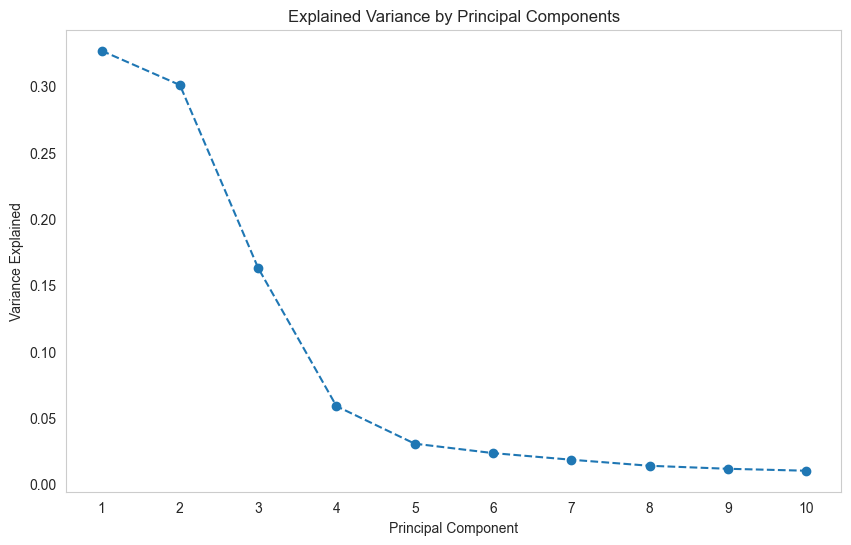

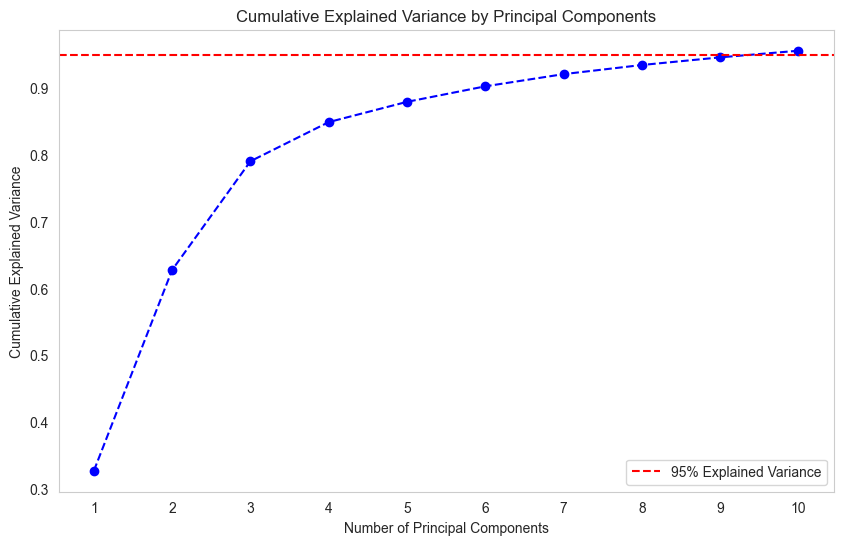

Explained variance ratio of each component:
[0.32682289 0.30092859 0.1628554  0.05865914 0.03035327 0.02325785
 0.01825483 0.01369673 0.01143164 0.00996512]
Shape of PCA transformed train data: (100, 10)
Shape of PCA transformed test data: (100, 10)


In [121]:
# First Stream

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# # Step 1: Standardize the Data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(train_features_for_dr)# `train_features_for_dr` is the DataFrame with selected features but without "unit_ID"
# X_test_scaled = scaler.transform(test_features_for_dr)

# Step 2: Fit PCA
pca = PCA(
    n_components=0.95
)  # This will keep enough components to explain 95% of the variance
""" retaining enough principal components to explain 95% of the variance in the data. 
This helps in reducing the dimensionality while preserving most of the information."""
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

"""X_train_pca and X_test_pca are now without unit_ID as they are not features for PCA"""

# Get the components
components = pca.components_
print("PCA Components:\n", components)

# Step 3: Explained Variance Visualization
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    pca.explained_variance_ratio_,
    marker="o",
    linestyle="--",
)
plt.title("Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.grid()
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.show()

# Step 4: Calculate the cumulative explained variance
"""
cumulative explained variance to get a clearer understanding of how many principal components 
are necessary to explain a desired percentage of the variance (e.g., 95%)
"""
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Cumulative Explained Variance by Principal Components plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o",
    linestyle="--",
    color="b",
)
plt.title("Cumulative Explained Variance by Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(
    y=0.95, color="r", linestyle="--", label="95% Explained Variance"
)  # Line at 95% threshold
plt.legend()
plt.grid()
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.show()

# Print the explained variance ratio
print("Explained variance ratio of each component:")
print(pca.explained_variance_ratio_)

# Check the shape of the transformed data
"""Shape of PCA Transformed Data
The shape of the PCA-transformed data is (100, 10), indicating that your dataset 
has been reduced to 10 principal components from the original number of features 
(which seems to be more than 10 based on the PCA results)."""
print("Shape of PCA transformed train data:", X_train_pca.shape)
print("Shape of PCA transformed test data:", X_test_pca.shape)

The output shows the explained variance ratio for each principal component and the shape of the PCA-transformed data. Here's how to interpret the results:

**Explained Variance Ratio**
The explained variance ratio indicates the proportion of the dataset's total variance that is captured by each principal component. Here’s the breakdown of your output:

`Component 1:` Captures approximately 32.68% of the variance.

`Component 2:` Captures approximately 30.09% of the variance.

`Component 3:` Captures approximately 16.29% of the variance.

`Component 4:` Captures approximately 5.87% of the variance.

`Component 5:` Captures approximately 3.04% of the variance.

`Component 6:` Captures approximately 2.33% of the variance.

`Component 7:` Captures approximately 1.83% of the variance.

`Component 8:` Captures approximately 1.37% of the variance.

`Component 9:` Captures approximately 1.14% of the variance.

`Component 10:` Captures approximately 0.99% of the variance.

**Scoring Function for predictions**

In [122]:
# Define the asymmetric scoring function
def asymmetric_score(y_true, y_pred):
    overestimate = y_pred > y_true
    score = np.where(
        overestimate,
        np.exp((y_pred - y_true) / 13) - 1,
        np.exp((y_true - y_pred) / 10) - 1,
    )
    return np.mean(score)

**Stream 1 Modeling: PCA**

**Model Selection and Training:**
Use neural network model LSTM, given the time-series nature of your data.Train the model using the PCA-transformed features (X_pca) and the corresponding labels (train_labels_repeated).

**Model Evaluation:**
Split your data into training and validation sets if you haven't already.Evaluate the model's performance using appropriate metrics such as RMSE (Root Mean Square Error) or MAE (Mean Absolute Error).Use cross-validation to ensure the model's robustness.

Epoch 1/200


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - loss: 7950.7998 - mae: 86.0013 - val_loss: 1087.4863 - val_mae: 35.4275 - learning_rate: 0.0010
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7623.9980 - mae: 84.2403 - val_loss: 1083.1913 - val_mae: 35.3599 - learning_rate: 0.0010
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7817.2612 - mae: 85.2170 - val_loss: 1079.0166 - val_mae: 35.2940 - learning_rate: 0.0010
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7031.6494 - mae: 80.6779 - val_loss: 1074.5229 - val_mae: 35.2221 - learning_rate: 0.0010
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7910.5405 - mae: 86.2512 - val_loss: 1069.9608 - val_mae: 35.1500 - learning_rate: 0.0010
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7268.9126 - mae: 82.5850 - val_loss: 1065.4143 - val_mae: 35.0784 - learning_rate: 0.0010
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7836.3398 - mae: 85.7953 - val_loss: 1060.4388 - val_mae: 35.0004

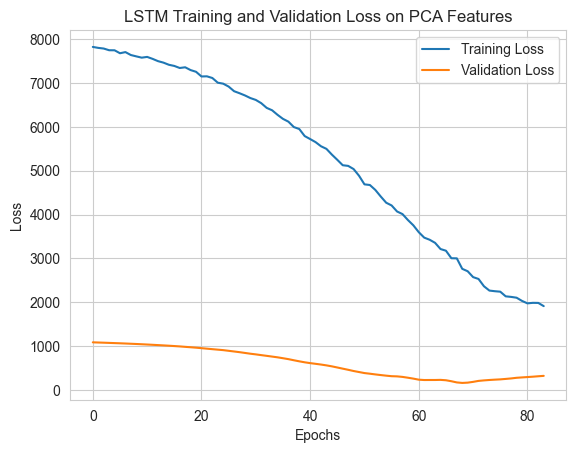

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
Validation RMSE: 13.900418953521836, Validation MAE: 10.592996501922608


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Fold RMSE: 90.33937303587035, Fold MAE: 90.10955536924303


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
Fold RMSE: 57.493469050660636, Fold MAE: 56.93292182683945


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Fold RMSE: 45.24972970358792, Fold MAE: 43.96580009162426


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
Fold RMSE: 13.175724384645568, Fold MAE: 11.155299305915833


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Fold RMSE: 7.108112458995052, Fold MAE: 5.540161728858948


In [123]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import Bidirectional  # Import the Bidirectional wrapper
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization
from keras.optimizers import Adam

""" 
X_pca and train_labels_repeated are already defined
X_pca should be a 2D array (samples, features)
train_labels_repeated should be a 1D array or 2D array with shape (samples, 1)"""


'''
Reshape the PCA features for LSTM
LSTM expects input shape to be (samples, time_steps, features)
Set time_steps = 1 for a simple LSTM model'''
time_steps = 1
X_train_pca_reshaped = X_train_pca.reshape(X_train_pca.shape[0], time_steps, X_train_pca.shape[1])

# Define the LSTM model
model = Sequential()
model.add(
    Bidirectional(
        LSTM(
            50,
            return_sequences=True,
            input_shape=(X_train_pca_reshaped.shape[1], X_train_pca_reshaped.shape[2]),
            # kernel_regularizer=regularizers.l2(0.005),
        )
    )
)  # Reduce L2 regularization

model.add(BatchNormalization())
model.add(Dropout(0.2))  # Reduced dropout rate

model.add(Bidirectional(LSTM(100)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
# model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
# Compile the model with a reduced batch size and adaptive learning rate
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mae"])

# Implement a learning rate scheduler
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)


# Train the model
early_stopping = EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True
)

history = model.fit(
    X_train_pca_reshaped,
    train_labels_repeated,
    epochs=200,
    batch_size=16,  # Smaller batch size
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM Training and Validation Loss on PCA Features")
plt.legend()
plt.show()

# Evaluate the model performance on validation set
"""
This is a validation test to monitor the model's performance during training and assess overfitting. It does not involve an independent test dataset.
"""
val_predictions = model.predict(X_train_pca_reshaped[int(0.8 * X_train_pca.shape[0]) :])
val_labels = train_labels_repeated[int(0.8 * train_labels_repeated.shape[0]) :]

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(val_labels, val_predictions))
mae = mean_absolute_error(val_labels, val_predictions)
print(f"Validation RMSE: {rmse}, Validation MAE: {mae}")

# Cross-validation using TimeSeriesSplit
"""
Cross-validation divides the training data into multiple training and validation folds, retraining the model on each fold and calculating metrics for each. 
This approach gives a more robust estimate of model performance but still does not use a held-out test set.
"""
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X_train_pca_reshaped):
    # Re-initialize the model for each fold
    model = Sequential()
    model.add(
        Bidirectional(LSTM(
            100,
            return_sequences=True,
            input_shape=(X_train_pca_reshaped.shape[1], X_train_pca_reshaped.shape[2]),
        ))
    )
    model.add(Dropout(0.3)) #prevent overfitting by dropping
    model.add(Bidirectional(LSTM(100)))  # Use Bidirectional LSTM
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

    X_train, X_test = X_train_pca_reshaped[train_index], X_train_pca_reshaped[test_index]
    y_train, y_test = (
        train_labels_repeated[train_index],
        train_labels_repeated[test_index],
    )

    # Train model on each fold
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    predictions = model.predict(X_test)



    # Calculate and print RMSE and MAE for each fold
    fold_rmse = np.sqrt(mean_squared_error(y_test, predictions))
    fold_mae = mean_absolute_error(y_test, predictions)
    fold_asymmetric_score = asymmetric_score(y_test, predictions)

    print(
        f"Fold RMSE: {fold_rmse}, Fold MAE: {fold_mae}"
    )

**Hyperparameter tuning**

In [124]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam


def create_model(lstm_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(
        Bidirectional(
            LSTM(
                lstm_units,
                return_sequences=True,
                input_shape=(
                    X_train_pca_reshaped.shape[1],
                    X_train_pca_reshaped.shape[2],
                ),
            )
        )
    )
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(lstm_units)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mae"],
    )
    return model

import itertools

# Define hyperparameter grid
lstm_units = [50, 100]
dropout_rates = [0.2, 0.3]
learning_rates = [0.001, 0.01]
batch_sizes = [16, 32]

param_grid = list(
    itertools.product(lstm_units, dropout_rates, learning_rates, batch_sizes)
)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

best_rmse = float("inf")
best_params = None

# Iterate over all combinations of hyperparameters
for units, dropout, lr, batch in param_grid:
    print(
        f"Testing with: LSTM Units={units}, Dropout Rate={dropout}, Learning Rate={lr}, Batch Size={batch}"
    )

    fold_rmse_list = []

    # TimeSeries cross-validation
    for train_index, test_index in tscv.split(X_train_pca_reshaped):
        # Split the data
        X_train, X_test = (
            X_train_pca_reshaped[train_index],
            X_train_pca_reshaped[test_index],
        )
        y_train, y_test = (
            train_labels_repeated[train_index],
            train_labels_repeated[test_index],
        )

        # Create and train the model
        model = create_model(lstm_units=units, dropout_rate=dropout, learning_rate=lr)
        model.fit(X_train, y_train, epochs=50, batch_size=batch, verbose=0)

        # Make predictions
        predictions = model.predict(X_test)

        # Calculate RMSE for this fold
        fold_rmse = np.sqrt(mean_squared_error(y_test, predictions))
        fold_rmse_list.append(fold_rmse)

    # Calculate mean RMSE across all folds
    mean_rmse = np.mean(fold_rmse_list)
    print(f"Mean RMSE: {mean_rmse}")

    # Update the best parameters if current mean RMSE is lower
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_params = (units, dropout, lr, batch)

print(
    f"Best Hyperparameters: LSTM Units={best_params[0]}, Dropout Rate={best_params[1]}, Learning Rate={best_params[2]}, Batch Size={best_params[3]}"
)
print(f"Best RMSE: {best_rmse}")

Testing with: LSTM Units=50, Dropout Rate=0.2, Learning Rate=0.001, Batch Size=16


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
Mean RMSE: 43.04169482876262
Testing with: LSTM Units=50, Dropout Rate=0.2, Learning Rate=0.001, Batch Size=32


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
Mean RMSE: 52.761346337306534
Testing with: LSTM Units=50, Dropout Rate=0.2, Learning Rate=0.01, Batch Size=16


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
Mean RMSE: 29.115915362361516
Testing with: LSTM Units=50, Dropout Rate=0.2, Learning Rate=0.01, Batch Size=32


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Mean RMSE: 33.40832284060427
Testing with: LSTM Units=50, Dropout Rate=0.3, Learning Rate=0.001, Batch Size=16


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
Mean RMSE: 43.517771400581566
Testing with: LSTM Units=50, Dropout Rate=0.3, Learning Rate=0.001, Batch Size=32


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
Mean RMSE: 53.870616906614146
Testing with: LSTM Units=50, Dropout Rate=0.3, Learning Rate=0.01, Batch Size=16


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
Mean RMSE: 30.272638770350273
Testing with: LSTM Units=50, Dropout Rate=0.3, Learning Rate=0.01, Batch Size=32


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
Mean RMSE: 32.320535676514865
Testing with: LSTM Units=100, Dropout Rate=0.2, Learning Rate=0.001, Batch Size=16


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Mean RMSE: 36.677567646861974
Testing with: LSTM Units=100, Dropout Rate=0.2, Learning Rate=0.001, Batch Size=32


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
Mean RMSE: 41.826544688714975
Testing with: LSTM Units=100, Dropout Rate=0.2, Learning Rate=0.01, Batch Size=16


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
Mean RMSE: 33.51521673703294
Testing with: LSTM Units=100, Dropout Rate=0.2, Learning Rate=0.01, Batch Size=32


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
Mean RMSE: 35.61663812597565
Testing with: LSTM Units=100, Dropout Rate=0.3, Learning Rate=0.001, Batch Size=16


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
Mean RMSE: 37.24196077924029
Testing with: LSTM Units=100, Dropout Rate=0.3, Learning Rate=0.001, Batch Size=32


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
Mean RMSE: 43.13175698451869
Testing with: LSTM Units=100, Dropout Rate=0.3, Learning Rate=0.01, Batch Size=16


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
Mean RMSE: 34.20059490757406
Testing with: LSTM Units=100, Dropout Rate=0.3, Learning Rate=0.01, Batch Size=32


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
Mean RMSE: 34.7775152527816
Best Hyperparameters: LSTM Units=50, Dropout Rate=0.2, Learning Rate=0.01, Batch Size=16
Best RMSE: 29.115915362361516


Epoch 1/100


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 7576.4756 - mae: 83.9225 - val_loss: 1042.6962 - val_mae: 34.7845
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7440.5527 - mae: 83.1569 - val_loss: 893.4804 - val_mae: 32.4416
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6259.7607 - mae: 76.0150 - val_loss: 625.9402 - val_mae: 27.4541
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5462.3511 - mae: 70.2169 - val_loss: 345.1557 - val_mae: 20.4627
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4747.5396 - mae: 65.2955 - val_loss: 141.4872 - val_mae: 12.8562
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3801.0903 - mae: 57.5525 - val_loss: 54.0079 - val_mae: 7.4823
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3357.9526 - mae: 53.1467 - val_loss: 42.2907 - val_mae: 5.4825
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2570.2542 - mae: 46.0888 - val_loss: 78.0642 - val_mae: 5.3775
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━

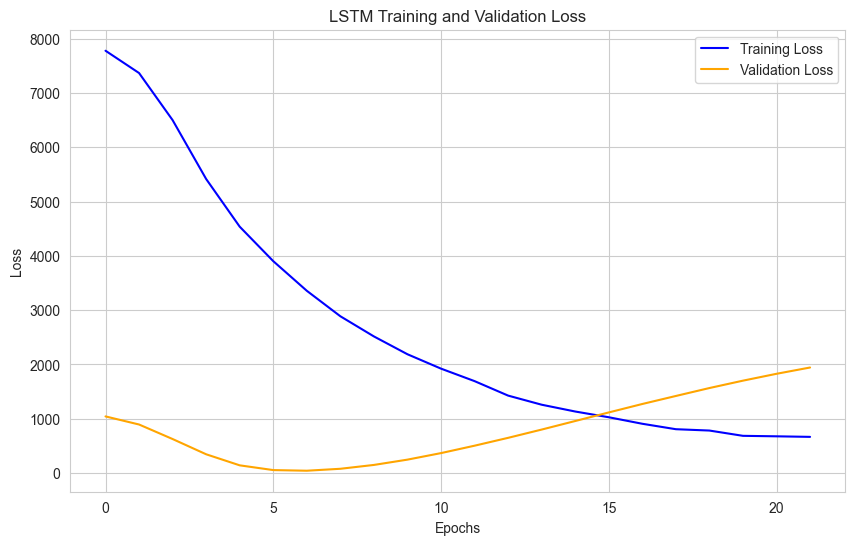

Final Model Validation RMSE: 6.100959280076501, Final Model Validation MAE: 5.482527446746826


In [125]:
# Retrieve the best hyperparameters
best_units, best_dropout, best_lr, best_batch = best_params

# Create the final model with the best hyperparameters
final_model = create_model(
    lstm_units=best_units, dropout_rate=best_dropout, learning_rate=best_lr
)

# Train the model on the entire training data
final_history = final_model.fit(
    X_train_pca_reshaped,
    train_labels_repeated,
    epochs=100,  # Adjust if needed for better results or earlier stopping
    batch_size=best_batch,
    validation_split=0.2,  # Optional: use a validation split if desired
    callbacks=[early_stopping],  # Optional: early stopping to avoid overfitting
)

# Evaluate on validation data (if available) or test data
final_val_predictions = final_model.predict(
    X_train_pca_reshaped[int(0.8 * X_train_pca.shape[0]) :]
)
final_val_labels = train_labels_repeated[int(0.8 * train_labels_repeated.shape[0]) :]


# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(final_history.history["loss"], label="Training Loss", color="blue")
plt.plot(final_history.history["val_loss"], label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE and MAE on validation set to confirm performance
final_rmse = np.sqrt(mean_squared_error(final_val_labels, final_val_predictions))
final_mae = mean_absolute_error(final_val_labels, final_val_predictions)
print(
    f"Final Model Validation RMSE: {final_rmse}, Final Model Validation MAE: {final_mae}"
)

**PCA LSTM Model Testing**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Test RMSE: 18.6391663814564, Test MAE: 15.858040924072265, Asymmetric Score: 4.13353679557345


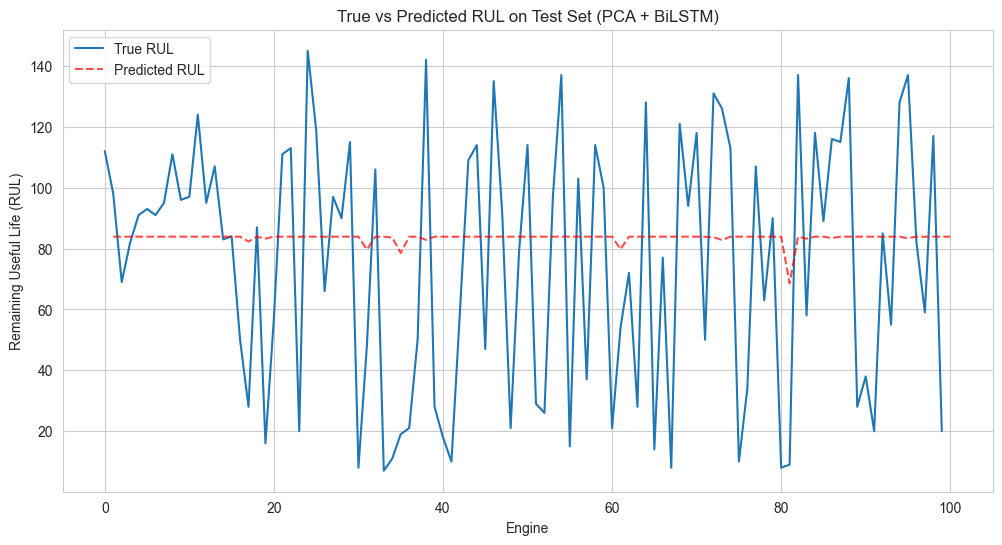

In [126]:
# Reshape test dataset for LSTM input
X_test_pca_reshaped = X_test_pca.reshape(X_test_pca.shape[0], time_steps, X_test_pca.shape[1])

# Make predictions to test for generalisability
test_predictions = model.predict(X_test_pca_reshaped) # `test_predictions` contains the predicted RUL values from your model

# Evaluate predictions with test_labels_repeated, labeled with true_rul
test_labels_series = pd.Series(test_labels_repeated)  # `test_labels_repeated` contains the true RUL values for the test set

# Create a DataFrame to combine unit IDs, true RUL, and predicted RUL for easier plotting
results_df = pd.DataFrame({
    'unit_ID': unit_ids_test,  # Unit IDs for the test set
    'True RUL': test_labels_repeated,  # True RUL values
    'Predicted RUL': test_predictions.flatten()  # Predicted RUL values (flatten if it's a 2D array)
})

# Ensure proper indexing for plotting
results_df.set_index('unit_ID', inplace=True)

# Calculate RMSE and MAE for the test set
test_rmse = np.sqrt(mean_squared_error(test_labels_series, test_predictions))
test_mae = mean_absolute_error(test_labels_series, test_predictions)
test_asymmetric_score = asymmetric_score(test_labels_series.values, test_predictions.flatten())

print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}, Asymmetric Score: {test_asymmetric_score}")

# Plotting true vs. predicted RUL for the test set
plt.figure(figsize=(12, 6))
plt.plot(rul_df["RUL"], label="True RUL")
plt.plot(results_df.index, results_df['Predicted RUL'], label="Predicted RUL", color="red", linestyle="--", alpha=0.7)
plt.xlabel("Engine")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title("True vs Predicted RUL on Test Set (PCA + BiLSTM)")
plt.legend()
plt.show()

**Verify results**

**Stream 2: Autoencoders**

Autoencoders, which learn compressed representations of data by training a neural network to output its own input, are excellent for capturing non-linear patterns in the data. Extract the encoded features from the bottleneck layer, which forms the second feature stream.

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.9505 - val_loss: 1.3377
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9222 - val_loss: 1.3373
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9044 - val_loss: 1.3385
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9150 - val_loss: 1.3409
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8600 - val_loss: 1.3413
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8597 - val_loss: 1.3398
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7989 - val_loss: 1.3344
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7979 - val_loss: 1.3232
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7590 - val_loss: 1.3067
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7215 - val_loss: 1.2839
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6772 - val_loss: 1.2539
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6354 - val_loss: 1.2138
E

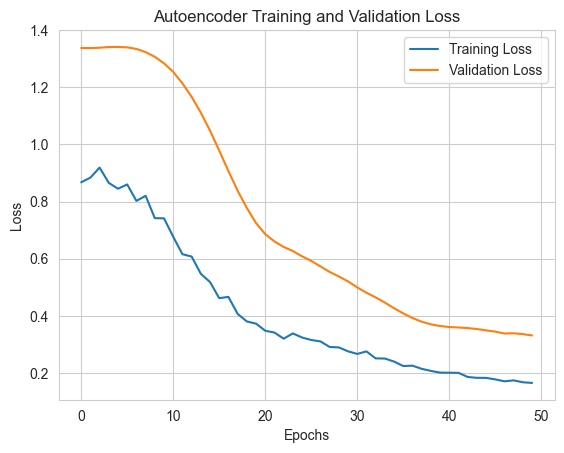

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
Shape of Autoencoder-transformed train data: (100, 10)
Shape of Autoencoder-transformed test data: (100, 10)


In [129]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# # Assuming `train_features_selected` is the original DataFrame with selected features
# # Step 1: Standardize the Data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(train_features_for_dr)
# X_test_scaled = scaler.transform(test_features_for_dr)

# Step 2: Define the Autoencoder
encoding_dim = 10  # Set the number of dimensions for compressed representation

# Input layer
input_layer = Input(shape=(X_train_scaled.shape[1],))

# Encoder network
encoded = Dense(64, activation="relu")(input_layer)
encoded = Dense(32, activation="relu")(encoded)
encoded = Dense(encoding_dim, activation="relu")(encoded)  # Bottleneck layer

# Decoder network
decoded = Dense(32, activation="relu")(encoded)
decoded = Dense(64, activation="relu")(decoded)
decoded = Dense(X_train_scaled.shape[1], activation="linear")(decoded)

# Compile Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")

# Step 3: Train the Autoencoder
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
history = autoencoder.fit(
    X_train_scaled,
    X_train_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1,
)

# Plotting training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Autoencoder Training and Validation Loss")
plt.legend()
plt.show()

# Step 4: Extract Compressed Features (Encoder Output)
# Create an encoder model to obtain the compressed features
encoder = Model(inputs=input_layer, outputs=encoded)
X_train_autoencoder = encoder.predict(X_train_scaled)
X_test_autoencoder = encoder.predict(X_test_scaled)

# Check the shape of the Autoencoder-transformed data
print("Shape of Autoencoder-transformed train data:", X_train_autoencoder.shape)
print("Shape of Autoencoder-transformed test data:", X_test_autoencoder.shape)

In [130]:
print("Missing values in training data:", train_features_selected.isnull().sum().sum())
print("Missing values in test data:", test_features_selected.isnull().sum().sum())
print("Data types in training data:\n", train_features_selected.dtypes)
print("Data types in test data:\n", test_features_selected.dtypes)
print("Training data shape:", train_features_selected.shape)
print("Test data shape:", test_features_selected.shape)

Missing values in training data: 0
Missing values in test data: 0
Data types in training data:
 unit_ID                    int64
384__sum_values          float64
400__sum_values          float64
416__sum_values          float64
400__mean                float64
                          ...   
224__median              float64
0__sum_values            float64
355__maximum             float64
355__absolute_maximum    float64
161__median              float64
Length: 186, dtype: object
Data types in test data:
 unit_ID                    int64
384__sum_values          float64
400__sum_values          float64
416__sum_values          float64
400__mean                float64
                          ...   
224__median              float64
0__sum_values            float64
355__maximum             float64
355__absolute_maximum    float64
161__median              float64
Length: 186, dtype: object
Training data shape: (100, 186)
Test data shape: (100, 186)


**Stream 2 Modeling: Autoencoders**

**Model Selection and Training:**
Utilize an LSTM-based autoencoder model to capture the sequential dependencies in time-series data effectively. Train the autoencoder on the original input features, allowing the model to learn a compressed representation of the data. The encoder component of the autoencoder will transform the input data into a lower-dimensional latent space, capturing essential features that can be used for further prediction or anomaly detection.

**Model Evaluation:**
Split the data into training and validation sets, if not done already, to monitor the model’s performance during training. Evaluate the autoencoder's reconstruction accuracy using metrics like RMSE (Root Mean Square Error) or MAE (Mean Absolute Error). Additionally, use cross-validation on the latent features or predictions to assess robustness and generalization across different data folds.

c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
Fold RMSE: 61.21956557711527, Fold MAE: 61.00826859474182


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
Fold RMSE: 13.469972858562818, Fold MAE: 11.442314147949219


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
Fold RMSE: 7.7417010263422315, Fold MAE: 5.782842397689819


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
Fold RMSE: 22.86083951722507, Fold MAE: 19.413209855556488


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
Fold RMSE: 15.717046759552957, Fold MAE: 12.05357737839222


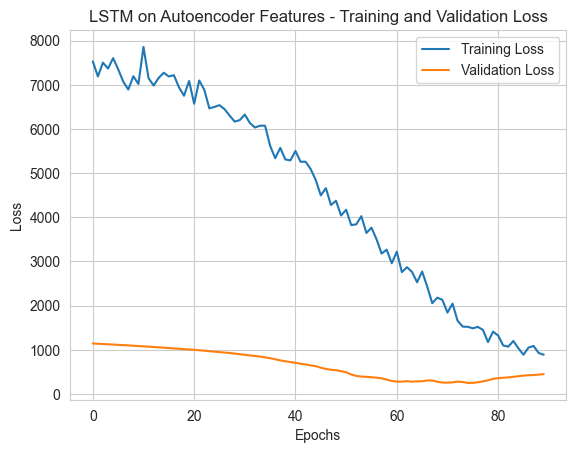

In [131]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from keras.optimizers import Adam
from keras.regularizers import l2  # Import l2 regularization


# Assuming X_train_pca and train_labels_repeated are already defined
# Reshape the PCA features for LSTM
time_steps = 1
X_train_pca_reshaped = X_train_pca.reshape(
    X_train_pca.shape[0], time_steps, X_train_pca.shape[1]
)


# Define and compile the initial model
def create_model():
    model = Sequential()
    model.add(
        Bidirectional(
            LSTM(
                50,
                return_sequences=True,
                kernel_regularizer=l2(0.01),  # L2 regularization
                input_shape=(
                    X_train_pca_reshaped.shape[1],
                    X_train_pca_reshaped.shape[2],
                ),
            )
        )
    )
    model.add(BatchNormalization())
    model.add(Dropout(0.3))  # Increased dropout rate
    model.add(Bidirectional(LSTM(100, kernel_regularizer=l2(0.01))))  # L2 regularization
    model.add(BatchNormalization())
    model.add(Dropout(0.3))  # Increased dropout rate
    model.add(Dense(1))

    # Create a new optimizer instance each time the model is created
    initial_learning_rate = 0.001
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mae"])
    return model


# Cross-validation using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X_train_pca_reshaped):
    # Re-initialize the model for each fold
    model = create_model()  # Call the function to create a new model

    X_train, X_test = (
        X_train_pca_reshaped[train_index],
        X_train_pca_reshaped[test_index],
    )
    y_train, y_test = (
        train_labels_repeated[train_index],
        train_labels_repeated[test_index],
    )

    # Implement early stopping and learning rate scheduler
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=15, restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6
    )

    # Train model on each fold
    history = model.fit(
        X_train,
        y_train,
        epochs=200,
        batch_size=16,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=0,
    )

    predictions = model.predict(X_test)

    # Calculate and print RMSE and MAE for each fold
    fold_rmse = np.sqrt(mean_squared_error(y_test, predictions))
    fold_mae = mean_absolute_error(y_test, predictions)
    
    print(f"Fold RMSE: {fold_rmse}, Fold MAE: {fold_mae}")

# Plot the training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM on Autoencoder Features - Training and Validation Loss")
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Test RMSE: 43.99130297793316, Test MAE: 39.51570804595947, Asymmetric Score: 287.76753888533176


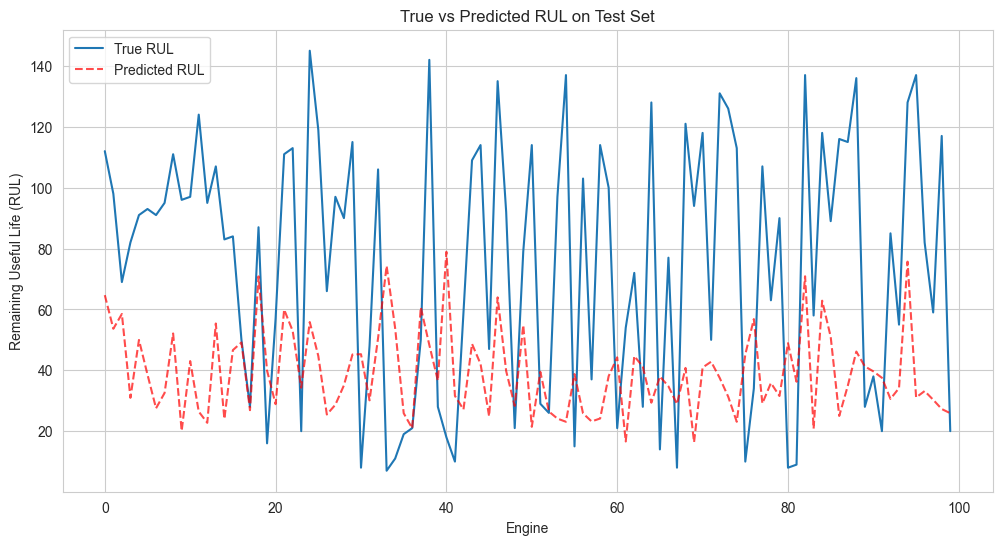

In [132]:
# Reshape the Autoencoder-transformed test data for LSTM input
X_test_autoencoder_reshaped = X_test_autoencoder.reshape(
    X_test_autoencoder.shape[0], time_steps, X_test_autoencoder.shape[1]
)

# Make predictions on the test set
test_predictions = model.predict(X_test_autoencoder_reshaped)

# Assuming `test_labels_repeated` is already defined and contains the true RUL values
test_labels_series = pd.Series(test_labels_repeated)  # Convert to Series if necessary

# Calculate RMSE and MAE for the test set
test_rmse = np.sqrt(mean_squared_error(test_labels_series, test_predictions))
test_mae = mean_absolute_error(test_labels_series, test_predictions)
test_asymmetric_score = asymmetric_score(test_labels_series.values, test_predictions.flatten())

print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}, Asymmetric Score: {test_asymmetric_score}")

# Optional: Plotting test predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(rul_df["RUL"], label="True RUL")
plt.plot(test_predictions, label="Predicted RUL", color="red", linestyle="--", alpha=0.7)
plt.xlabel("Engine")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title("True vs Predicted RUL on Test Set")
plt.legend()
plt.show()

If the validation loss is consistently **below the training loss** in the PCA-LSTM method but **above the training loss** in the Autoencoder-LSTM method, it likely suggests that the PCA and Autoencoder are affecting the feature representations in distinct ways, leading to different model behaviors:

##### 1. **PCA-LSTM (Validation Loss < Training Loss)**:
   - **Simplified Feature Representation**: PCA reduces the dataset to its principal components, which often capture the most important patterns and filter out noise. This can make it easier for the model to generalize, as it focuses on the main signals in the data rather than overfitting on minor fluctuations.
   - **Possible Underfitting**: Since the training loss is higher than the validation loss, it might indicate that the model is underfitting (not learning the training data patterns perfectly). In this case, PCA’s dimensionality reduction may have caused some loss of information, leading to a less complex representation that generalizes well but lacks some detail.
   
##### 2. **Autoencoder-LSTM (Training Loss < Validation Loss)**:
   - **Complexity of Representation**: The autoencoder’s feature extraction can sometimes create more complex representations of the data, retaining more information than PCA. While this detail is valuable, it can also lead to overfitting, where the model fits the training data well but struggles with new (validation) data.
   - **Potential Overfitting**: The lower training loss compared to the validation loss suggests the model is potentially overfitting, especially if the autoencoder is complex and captures subtle patterns that may not generalize well to unseen data.

In general, PCA often produces simpler representations, whereas an autoencoder can capture more complex and nuanced patterns, which may contribute to these different behaviors in validation loss versus training loss.

### **Late Fusion to enhance predictive performance:**

The differing behaviors of the PCA-LSTM and Autoencoder-LSTM models can be beneficial for a fusion approach. Here's why:

##### 1. **Diversity in Feature Representations**:
- **PCA-LSTM**: By capturing the most significant patterns while filtering out noise, the PCA-LSTM may provide a cleaner, more generalizable feature set. This can help mitigate the risk of overfitting, offering robust predictions based on the essential characteristics of the data.
- **Autoencoder-LSTM**: On the other hand, the Autoencoder-LSTM's ability to retain complex relationships and details in the data can capture subtler patterns that might be overlooked by PCA. This depth of information can enhance the predictive power when combined with the simpler PCA features.

##### 2. **Late Fusion Advantages**:
- **Complementary Strengths**: By fusing the outputs from both models, you leverage the strengths of each. The PCA-LSTM can provide stable, generalizable predictions, while the Autoencoder-LSTM can introduce nuance and detail. Together, they can create a more robust final prediction by combining these complementary insights.
- **Improved Generalization**: In a fusion method, if one model struggles in certain scenarios (like the Autoencoder-LSTM with unseen data), the other model can potentially compensate, leading to improved overall performance.
  
##### 3. **Ensemble Learning Benefits**:
- **Reduced Variance**: Combining models can help reduce variance, which is especially valuable if the individual models are prone to overfitting (as in the case of Autoencoder-LSTM). The ensemble can balance out the noise and reduce the impact of outliers.
- **Risk Mitigation**: If one model fails to perform well in certain conditions, the other model's predictions may still be reliable, thus mitigating risks associated with model uncertainty.

##### Late Fusion to enhance predictive performance:
Using both PCA-LSTM and Autoencoder-LSTM in a late fusion method allows for a richer, more nuanced approach to modeling, capitalizing on the strengths and weaknesses of each technique. The variations in training and validation loss not only indicate different modeling behaviors but also provide an opportunity to create a more effective combined model, ultimately enhancing predictive performance and robustness.

In [133]:
# Combine PCA and Autoencoder features for Late Fusion
# Assuming X_train_pca is the feature set from PCA, already computed
X_train_fused = np.hstack((X_train_pca, X_train_autoencoder))

X_test_fused = np.hstack((X_test_pca, X_test_autoencoder))

print("Shape of Fused Feature Train Data:", X_train_fused.shape)
print("Shape of Fused Feature Test Data:", X_test_fused.shape)

Shape of Fused Feature Train Data: (100, 20)
Shape of Fused Feature Test Data: (100, 20)


In [134]:
# LSTM Model on Fused Features
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Reshape the Fused Features for LSTM
time_steps = 1
X_train_fused_reshaped = X_train_fused.reshape(X_train_fused.shape[0], time_steps, X_train_fused.shape[1])

# Define LSTM Model
model = Sequential()
model.add(
    Bidirectional(LSTM(
        50,
        return_sequences=True,
        input_shape=(X_train_fused_reshaped.shape[1], X_train_fused_reshaped.shape[2]),
    ))
)
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50)))  # Use Bidirectional LSTM
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# Train the LSTM Model with Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
history = model.fit(
    X_train_fused_reshaped,
    train_labels_repeated,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
)

# Evaluate Model Performance
val_predictions = model.predict(X_train_fused_reshaped[int(0.8 * X_train_fused.shape[0]) :])
val_labels = train_labels_repeated[int(0.8 * train_labels_repeated.shape[0]) :]
rmse = np.sqrt(mean_squared_error(val_labels, val_predictions))
mae = mean_absolute_error(val_labels, val_predictions)
print(f"Validation RMSE: {rmse}, Validation MAE: {mae}")

# Cross-Validation using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X_train_fused_reshaped):
    model = Sequential()
    model.add(
    Bidirectional(LSTM(
            50,
            return_sequences=True,
            input_shape=(X_train_fused_reshaped.shape[1], X_train_fused_reshaped.shape[2]),
        ))
    )
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50)))  # Use Bidirectional LSTM
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

    X_train, X_test = X_train_fused_reshaped[train_index], X_train_fused_reshaped[test_index]
    y_train, y_test = (
        train_labels_repeated[train_index],
        train_labels_repeated[test_index],
    )

    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    predictions = model.predict(X_test)

    fold_rmse = np.sqrt(mean_squared_error(y_test, predictions))
    fold_mae = mean_absolute_error(y_test, predictions)
    print(f"Fold RMSE: {fold_rmse}, Fold MAE: {fold_mae}")

Epoch 1/50


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - loss: 7741.8804 - mae: 84.4376 - val_loss: 1288.5133 - val_mae: 35.4301
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8007.8555 - mae: 87.2937 - val_loss: 1280.9513 - val_mae: 35.3238
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7764.4463 - mae: 85.2011 - val_loss: 1272.5388 - val_mae: 35.2053
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7764.7485 - mae: 84.8478 - val_loss: 1262.7175 - val_mae: 35.0665
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7613.6157 - mae: 84.4377 - val_loss: 1250.8960 - val_mae: 34.8987
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7792.7432 - mae: 85.0653 - val_loss: 1236.3008 - val_mae: 34.6904
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7554.6309 - mae: 84.1437 - val_loss: 1218.3572 - val_mae: 34.4326
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7666.0059 - mae: 84.2661 - val_loss: 1196.0930 - val_mae: 34.1101
Epoch 9/50
3/3 ━━━━━━━━━━━

c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Fold RMSE: 89.20319216840984, Fold MAE: 89.07532477378845


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Fold RMSE: 64.49816529431357, Fold MAE: 64.33051788806915


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Fold RMSE: 47.99011760780195, Fold MAE: 47.79085326194763


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
Fold RMSE: 26.113121486284907, Fold MAE: 25.701870679855347


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Fold RMSE: 10.589621850729305, Fold MAE: 9.544358134269714


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Test RMSE: 56.96129943665729, Test MAE: 54.10149461746216, Asymmetric Score: 831.6327054168696


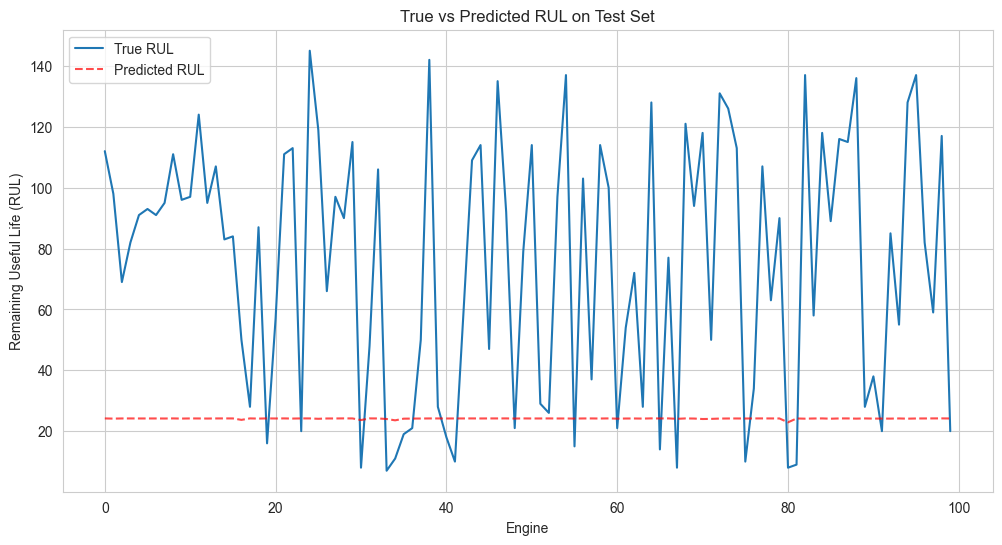

In [135]:
# Reshape the Fused Test Features for LSTM input
X_test_fused_reshaped = X_test_fused.reshape(X_test_fused.shape[0], time_steps, X_test_fused.shape[1])

# Make predictions on the test set
test_predictions = model.predict(X_test_fused_reshaped)

# Assuming you have test_labels_repeated for evaluating predictions
# Convert to a Pandas Series for easier handling if needed
test_labels_series = pd.Series(test_labels_repeated)

# Calculate RMSE and MAE for the test set
test_rmse = np.sqrt(mean_squared_error(test_labels_series, test_predictions))
test_mae = mean_absolute_error(test_labels_series, test_predictions)
test_asymmetric_score = asymmetric_score(test_labels_series.values, test_predictions.flatten())

print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}, Asymmetric Score: {test_asymmetric_score}")

# Optionally, plot True vs Predicted RUL for the test dataset
import matplotlib.pyplot as plt

# Create a DataFrame to combine unit IDs, true RUL, and predicted RUL for easier plotting
results_df_test = pd.DataFrame({
    'unit_ID': unit_ids_test,  # Unit IDs for the test set
    'True RUL': test_labels_repeated,  # True RUL values
    'Predicted RUL': test_predictions.flatten()  # Predicted RUL values
})

# Plotting true vs. predicted RUL against unit_ID
plt.figure(figsize=(12, 6))
plt.plot(rul_df["RUL"], label="True RUL")
plt.plot(test_predictions, label="Predicted RUL", color="red", linestyle="--", alpha=0.7)
plt.xlabel("Engine")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title("True vs Predicted RUL on Test Set")
plt.legend()
plt.show()

**Training and Validation Loss:**

The training loss and mean absolute error (MAE) are decreasing over the epochs, which is a good sign that the model is learning.The validation loss and MAE are also decreasing, indicating that the model is generalizing well to unseen data.

**Cross-Validation Results:**

The fold-wise RMSE and MAE values are decreasing across the folds, which suggests that the model's performance is improving with each fold.The final fold shows significantly lower RMSE and MAE, indicating better performance on that particular subset of data.

### **Hyperparameter Tuning:**
we used a Late fusion approach by combining features from PCA and an autoencoder before feeding them into a bidirectional LSTM model. Late fusion occurs when features from different sources (like PCA and autoencoder outputs) are concatenated before the learning model, as seen in our X_fused variable.

To perform hyperparameter tuning for our bidirectional LSTM model effectively, we will be using **Automated Machine Learning (AutoML) Tools**: Tools like Keras Tuner, AutoKeras, or TPOT can automate the process of hyperparameter tuning using various strategies.

In [136]:
# pip install keras-tuner

In [137]:
from kerastuner.tuners import RandomSearch


# Define a function to build the model
def build_model(hp):
    model = Sequential()
    model.add(
        Bidirectional(
            LSTM(
                hp.Int("units", min_value=32, max_value=128, step=16),
                return_sequences=True,
                input_shape=(X_train_fused_reshaped.shape[1], X_train_fused_reshaped.shape[2]),
            )
        )
    )
    model.add(Dropout(hp.Float("dropout", 0.1, 0.5, step=0.1)))
    model.add(
        Bidirectional(LSTM(hp.Int("units", min_value=32, max_value=128, step=16)))
    )
    model.add(Dropout(hp.Float("dropout", 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    return model


# Initialize Keras Tuner
tuner = RandomSearch(
    build_model,
    objective="val_mae",
    max_trials=10,
    executions_per_trial=1,
    directory="my_dir",
    project_name="helloworld",
)

# Perform hyperparameter tuning
tuner.search(X_train_fused_reshaped, train_labels_repeated, epochs=50, validation_split=0.2)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(best_hyperparameters.values)

Reloading Tuner from my_dir\helloworld\tuner0.json
Best hyperparameters:
{'units': 96, 'dropout': 0.2}


c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\zihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


**Testing for generalizability:**

Once you have a well-performing model, test it on your test dataset to evaluate its generalization capability.

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
Test RMSE: 41.96132963991276, Test MAE: 37.98886810302734, Asymmetric Score: 165.36507587477726


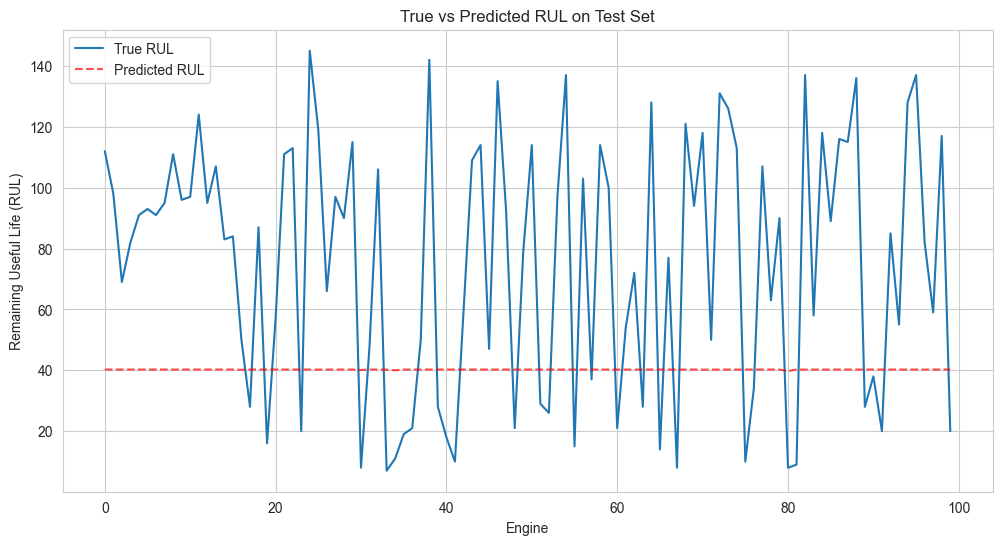

In [138]:
# Reshape the Test Data using the same time steps
X_test_fused_reshaped = X_test_fused.reshape(X_test_fused.shape[0], time_steps, X_test_fused.shape[1])

# Make predictions on the test set using the best model
test_predictions = best_model.predict(X_test_fused_reshaped)

# Assuming you have test_labels_repeated for evaluating predictions
# Convert to a Pandas Series for easier handling if needed
test_labels_series = pd.Series(test_labels_repeated)

# Calculate RMSE and MAE for the test set
test_rmse = np.sqrt(mean_squared_error(test_labels_series, test_predictions))
test_mae = mean_absolute_error(test_labels_series, test_predictions)
test_asymmetric_score = asymmetric_score(test_labels_series.values, test_predictions.flatten())

print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}, Asymmetric Score: {test_asymmetric_score}")

# Optionally, plot True vs Predicted RUL for the test dataset
import matplotlib.pyplot as plt

# Create a DataFrame to combine unit IDs, true RUL, and predicted RUL for easier plotting
results_df_test = pd.DataFrame({
    'unit_ID': unit_ids_test,  # Unit IDs for the test set
    'True RUL': test_labels_repeated,  # True RUL values
    'Predicted RUL': test_predictions.flatten()  # Predicted RUL values
})

# Plotting true vs. predicted RUL against unit_ID
plt.figure(figsize=(12, 6))
plt.plot(rul_df["RUL"], label="True RUL")
plt.plot(test_predictions, label="Predicted RUL", color="red", linestyle="--", alpha=0.7)
plt.xlabel("Engine")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title("True vs Predicted RUL on Test Set")
plt.legend()
plt.show()




`Best val_mae So Far` metric, which indicates the minimum validation mean absolute error (MAE) achieved during the hyperparameter tuning process.

**Interpretation of Your Output:**
- Best val_mae So Far: 5.05963659286499
- val_mae for Trial 10: 12.562060356140137

This means that the model associated with the hyperparameters leading to a validation MAE of ***5.0596*** is currently the best model.

Model Interpretation:
Analyze the model's predictions and interpret the results. This could involve looking at feature importances or visualizing predictions versus actual values.

**Value and complexity of feature fusion**

The high RMSE values across the validation and test sets show that the Two-Stream Network Bi-directional LSTM model with Late Fusion did not perform up to anticipated standards. The integration of PCA and Autoencoder-based feature streams might have increased testing error significantly. While the fusion attempts to collect complementary linear and non-linear feature representations, it might have added complexity. The higher training loss in comparison to validation loss indicates that the model showed a capacity to generalize on validation data more efficiently than on unknown test data, even if both training and validation losses showed a decreasing trend. When combined with the application of L2 regularization, this discovery suggests that the model may have a propensity to prioritize pertinent features above identifying more general patterns in the data


**Conclusion and Future work**

Two-Stream Network Bi-directional LSTM model with Late Fusion’s results suggest that while the application of regularization and dropout helped mitigate overfitting, they were insufficient to fully address the model's generalization limitations, particularly on complex, high-dimensional data. Among the three configurations tested, Stream 1, Stream 2 and ultimately the fusion approach, the PCA+Bi-LSTM (Stream 1) architecture yielded the best results, indicating that a simpler structure with dimensionality reduction may be more effective than complex architectures in this context. Conversely, the Autoencoder+Bi-LSTM (Stream 2) approach, while advantageous for feature extraction, appears to require further fine-tuning to optimize performance. The relatively high test RMSE for the Two-Stream Bi-LSTM with Late Fusion suggests that the increased complexity from combining two feature extraction streams introduced noise rather than enhancing predictive accuracy, highlighting the challenges of fusing disparate feature representations without careful model calibration.

Future research should consider more advanced feature reduction or selection methodologies, such as a secondary PCA application or advanced feature importance analysis, to enhance the interpretability and relevance of selected features. Additionally, data augmentation techniques could be explored to expand the variability within the training set, potentially enhancing the model’s capacity for generalization. Further hyperparameter optimization needs to be tested to get the best configurations that capture patterns in target variables while maintaining a balance between complexity and generalizability. Alternative fusion approaches, such as early fusion or attention mechanisms also leveraging multi-stream inputs, should also be investigated and possibly improving test set performance.
